In [1]:
# Importing the libraries
import pandas as pd
import numpy as np
import pickle
import os
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
from sklearn.metrics.pairwise import cosine_similarity
from plotnine import *


In [2]:

main_data_path = 'main_dataset.pkl'
tmp_data_path = 'tmp_dataset.pkl'
dir_path = './3DMolMS-with-ornl/check_point'
check_point_paths = ['Medium_from_start', 'CosSim']#['CosSim', 'Medium', 'Medium_from_start']
# Best ref model
best_ref_model = 'Medium_from_start'

def compute_r_squared(group):
    y_true = group['y']
    y_pred = group['pred']
    r2score = r2_score(y_true, y_pred)
    group['R2'] = r2score
    return group

# Compute cosine similarity
def compute_cosine_similarity(group):
    y_true = group['y']
    y_pred = group['pred']
    # Pairwise multiply the two vectors
    y_prod = np.multiply(y_true, y_pred)
    # Compute the norm of the two vectors
    y_true_norm = np.linalg.norm(y_true)
    y_pred_norm = np.linalg.norm(y_pred)
    cosine_similarity = np.sum(y_prod)/(y_true_norm*y_pred_norm)

    group['cosine_sim'] = cosine_similarity
    return group

#If file data_validation exists, load it
if os.path.isfile(tmp_data_path):
    df = pd.read_pickle(tmp_data_path)
else:    
    data_from_model_path = os.path.join(dir_path, best_ref_model)
    data_from_model_path = os.path.join(data_from_model_path, 'predictions')
    data_from_model_path = os.path.join(data_from_model_path, 'train')
    
    file_path = 'pred.csv'
    file_path = os.path.join(data_from_model_path, file_path)
    df_pred = pd.read_csv(file_path)

    file_path = 'pred_small.csv'
    file_path = os.path.join(data_from_model_path, file_path)
    df_pred_small = pd.read_csv(file_path)

    # Combine the two dataframes
    df_pred = pd.concat([df_pred, df_pred_small], ignore_index=True)
    # Add varaiable called dataset with value train
    df_pred['dataset'] = 'train'
    
    # Importing the dataset
    for i, check_point_path in enumerate(check_point_paths):
        data_from_model_path = os.path.join(dir_path, check_point_path)
        data_from_model_path = os.path.join(data_from_model_path, 'predictions')
        data_from_model_path = os.path.join(data_from_model_path, 'validation')
        file_path = 'pred.csv'
        file_path = os.path.join(data_from_model_path, file_path)        
        # Read file if it exists
        if os.path.isfile(file_path):
            df_tmp = pd.read_csv(file_path)

            file_path = 'pred_small.csv'
            file_path = os.path.join(data_from_model_path, file_path)
            assert os.path.isfile(file_path)
            df_tmp_small = pd.read_csv(file_path)

            # Combine the two dataframes
            df_tmp = pd.concat([df_tmp, df_tmp_small], ignore_index=True)
            df_tmp['dataset'] = 'validation' + '_' + str(i)
            df_pred = pd.concat([df_pred, df_tmp], ignore_index=True)

    # Save the dataframe
    df_pred = df_pred.sort_values(by=['model', 'smiles', 'nm'])
    df_pred = df_pred.reset_index(drop=True)
    # Group by model and smiles and normalize the pred by the max value
    df_pred['pred'] = df_pred.groupby(['model', 'smiles'])['pred'].transform(lambda x: x/x.max())
    df_pred['y'] = df_pred.groupby(['model', 'smiles'])['y'].transform(lambda x: x/x.max())
    df_pred.to_pickle(tmp_data_path)
    
    df = df_pred.copy()


In [3]:
from multiprocessing import Pool

def process_file(pair):
    smiles = pair[1]['smiles']
    title = pair[1]['title']
    
    # Print the shape of df_attentive_fp
    spectra = df_attentive_fp[smiles]
    # Pad the spectra to 171 with the last value in the spectra
    spectra = np.pad(spectra, (0, 1), 'constant', constant_values=(spectra.iloc[0], spectra.iloc[-1]))
    true_spectra = df_pred[(df_pred['smiles'] == smiles) & (df_pred['title'] == title) & (df_pred['dataset'] == 'validation_0')]['y'].values
    df_tmp2 = pd.DataFrame()
    df_tmp2['nm'] = nm_vec
    df_tmp2['pred'] = spectra
    df_tmp2['y'] = true_spectra
    # Add model, title and smiles to df_tmp2
    df_tmp2['model'] = model
    df_tmp2['title'] = title
    df_tmp2['smiles'] = smiles
    df_tmp2['group_id'] = model + '_' + smiles
    df_tmp2['dataset'] = 'validation'
    # Shuffle the varaiable order to match the order in df_pred
    df_tmp2 = df_tmp2[['model', 'title', 'smiles', 'nm', 'pred', 'y', 'group_id', 'dataset']]
    df_tmp2 = df_tmp2.reset_index(drop=True)
    
    return df_tmp2
    #df_res = df_res.reset_index(drop=True)
    #df_res = pd.concat([df_res, df_tmp2])


In [5]:
from multiprocessing import Pool, cpu_count

data_attentive_fp_path = './AttentiveFP_data'
models = ['AttentiveFP_CS', 'AttentiveFP_CS_rep', 'AttentiveFP_MSE', 'AttentiveFP_MSE_rep']
# List files in dir data_attentive_fp_path
files = os.listdir(data_attentive_fp_path)
dfs = [] 
# Load tmp_data_path
df_pred = pd.read_pickle(tmp_data_path)
# Put all unique smiles from dataset = validation in a list
#smiles_vec_val = df[df['dataset'] == 'validation']['smiles'].unique()
smiles_vec_train = df[df['dataset'] == 'train']['smiles'].unique()


nm_vec = df_pred['nm'].unique()
if __name__ == '__main__':
    for file in files:
        if 'train' in file:
            continue
        file_path = os.path.join(data_attentive_fp_path, file)
        # Print current jobb
        print("Currently processing: ", file_path)
        df_attentive_fp = pd.read_csv(file_path)
        # Set values below 0 to 0
        df_attentive_fp.iloc[:,1:] = df_attentive_fp.iloc[:,1:].apply(lambda x: np.where(x < 0, 0, x))

        # Square all numerical values in df_attentive_fp, column 1 to end
        #df_attentive_fp.iloc[:,1:] = df_attentive_fp.iloc[:,1:].apply(lambda x: np.sqrt(x))

        # Normalize the values in df_attentive_fp, column 1 to end
        df_attentive_fp.iloc[:,1:] = df_attentive_fp.iloc[:,1:].apply(lambda x: x/x.max())
        
        # Set variable name on column 0 to 'smiles'
        df_attentive_fp = df_attentive_fp.rename(columns={df_attentive_fp.columns[0]: 'smiles'})
        df_attentive_fp = df_attentive_fp.sort_values(by=['smiles'])


        # Flip df_attentive_fp so smiles are variables and index 1 to end are values
        df_attentive_fp = df_attentive_fp.set_index('smiles').T
        # If file contains 'train' in the name, read it
        if 'train' in file:
            continue
        
            df_tmp = df_pred[df_pred['dataset'] == 'train'][['smiles', 'title']].drop_duplicates()
            # Chage varaible names in df_attentive_fp to smiles

            df_attentive_fp.columns = smiles_vec_train
            if 'MSE' in file:
                model = models[3]
            else:
                model = models[1]
        else:
            df_tmp = df_pred[df_pred['dataset'] == 'validation_0'][['smiles', 'title']].drop_duplicates()
            if 'MSE' in file:
                model = models[2]
            else:
                model = models[0]
        # Set the maximum number of cores to 8
        num_cores = 16
        with Pool(processes=num_cores) as p:
            paris = list(df_tmp.iterrows())
            results = p.map(process_file, paris)
        print(len(results), len(results[0]))

        # Concat the list of dataframes and df_pred
        df_res = pd.concat(results, ignore_index=True)
        df_res = df_res.reset_index(drop=True)
        df_res = df_res.sort_values(by=['model', 'smiles', 'nm'])
        df_res = df_res.reset_index(drop=True)
        dfs.append(df_res)
    df_res = pd.concat(dfs, ignore_index=True)
    df_res = df_res.reset_index(drop=True)
    df_res = df_res.sort_values(by=['model', 'smiles', 'nm'])
    df_res = df_res.reset_index(drop=True)
    df_pred = pd.read_pickle(tmp_data_path)

    df_pred = df_pred.reset_index(drop=True)
    df_pred = df_pred.sort_values(by=['model', 'smiles', 'nm'])
    df_pred = df_pred.reset_index(drop=True)

    # Sort df_pred by model, smiles, nm
    df_pred = pd.concat([df_pred, df_res])
    # Grouped by model and smiles and put the MAE, R2 and add variables to df_pred
    df_pred['abs_error'] = np.abs(df_pred['y'] - df_pred['pred'])
    # Grouped by pairs of model and smiles comopute the mean of abs_error
    df_MAE = df_pred.groupby(['group_id'])['abs_error'].mean()
    # Grouped by pairs of model and smiles comopute the mean of abs_error
    df_MAE = df_pred.groupby(['group_id'])['abs_error'].mean()
    # Add the MAE to df_pred and match the model and smiles
    df_pred = df_pred.merge(df_MAE, on=['group_id'])
    df_pred = df_pred.drop(columns=['abs_error_x'])
    # Rename the column to MAE and drop the abs_error column
    df_pred = df_pred.rename(columns={'abs_error_y': 'MAE'})
    df_pred.to_pickle(main_data_path)

Currently processing:  ./AttentiveFP_data/data_attentiveFP_val_MSE.csv
9701 171
Currently processing:  ./AttentiveFP_data/data_attentiveFP_val_cosine.csv
9701 171


In [13]:
cbPalette = ["#E69F00", "#56B4E9", "#009E73", 
             "#0072B2", "#D55E00", 
             "#CC79A7", "#F0E442", "#999999"]

df = pd.read_pickle(main_data_path)


df_unique = df.drop(df[df['dataset'] == 'train'].index)
df_unique['pred'] = df_unique.groupby('group_id')['pred'].transform(lambda x: x/x.max())

# Grouped by model and smiles and put the MAE, R2 and add variables to df_pred
df_unique['abs_error'] = np.abs(df_unique['y'] - df_unique['pred'])
# Grouped by pairs of model and smiles comopute the mean of abs_error
df_MAE = df_unique.groupby(['group_id'])['abs_error'].mean()


# Add the MAE to df_pred and match the model and smiles
df_unique = df_unique.merge(df_MAE, on=['group_id'])



df_unique = df_unique.drop(columns=['abs_error_x'])
df_unique = df_unique.drop(columns=['MAE'])
# Rename the column to MAE and drop the abs_error column
df_unique = df_unique.rename(columns={'abs_error_y': 'MAE'})


             model       MAE
0       3DMolMS_CS  0.091272
1   AttentiveFP_CS  0.079099
2  AttentiveFP_MSE  0.061456
3      3DMolMS_MSE  0.059813


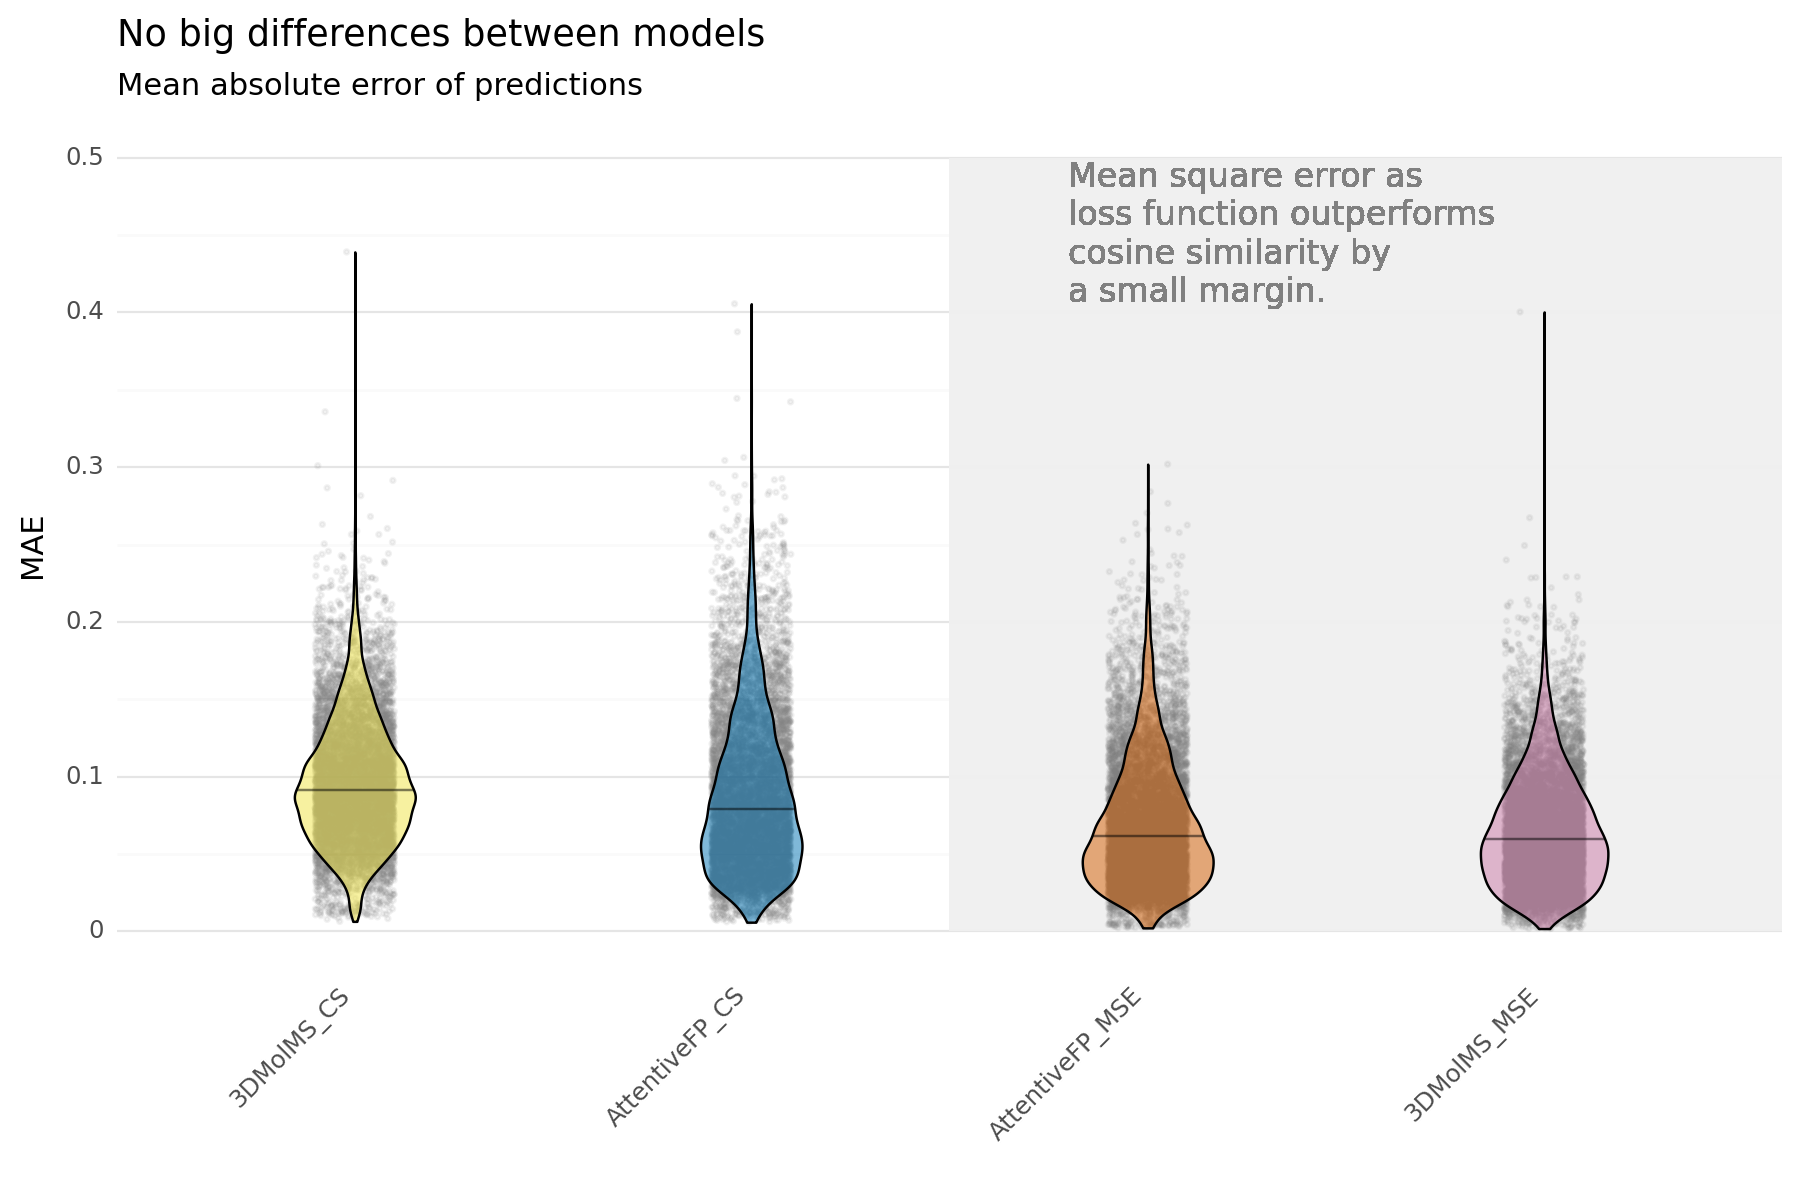

<Figure Size: (900 x 600)>

In [17]:

# Drop duplicates based on 'model_smiles'
df_unique = df_unique.drop_duplicates(subset='group_id')
order = ['3DMolMS_CS', 'AttentiveFP_CS', 'AttentiveFP_MSE', '3DMolMS_MSE']
# Order the models in order list
df_unique['model'] = pd.Categorical(df_unique['model'], order)

# For each model, compute the meadian of MAE
df_median = df_unique.groupby(['model'])['MAE'].median().reset_index()
print(df_median)
# Normalize the pred by the max value in each group
df_unique['pred'] = df_unique.groupby(['group_id'])['pred']
# Now proceed with your existing code but use df_unique instead of df
p = (ggplot(df_unique, aes('model', 'MAE', fill='model'))
     # Add grey area for MAE
    + geom_rect(xmin=2.5, xmax=8.75, ymin=0, ymax=0.5, alpha=0.5, fill='#f0f0f0')
    + geom_jitter(df_unique, aes(group='group_id'), width=0.1, size=0.5, alpha=0.1, color='grey', fill=None)
    + geom_violin(width=0.33, draw_quantiles=[0.5], alpha=0.5, color='black')
    + guides(fill=False)
    # Change model names
    + scale_fill_manual(values=[cbPalette[6], cbPalette[3], cbPalette[4], cbPalette[5], 'black'])
    + labs(y = 'MAE', x = '', title='No big differences between models', subtitle='Mean absolute error of predictions', fill='Model')
    + geom_text(x = 2.8, y = 0.45, ha="left",label="Mean square error as\nloss function outperforms\ncosine similarity by\na small margin.",size=12, color="grey")
    # Put grid lines above the geom_rect
    # Set vertical scale fraom 0 to 1
    + ylim(0, 0.5)
    + theme_minimal()
    # Remove vertical grid lines
    + theme(panel_grid_major_x=element_blank())
    # Tilt the x-axis labels 45 degrees
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
    +theme(figure_size=(9, 6))
)
p



9701


/tmp/ipykernel_25252/2047447956.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_25252/2047447956.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_25252/2047447956.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_2525

['Cn1nc(C(=O)N2CCN(c3nc(N)nc(C4CC4)n3)CC2)cc1C(O)(F)F', 'Cc1cc(OCCN2CCN(C)CC2)ccc1NC(=NCc1ccccc1)C1(N(C)C)CCC1', 'CCc1c(C(=O)COC(=O)CCc2ccc(OC(O)(F)F)cc2)[nH]c(C)c1C(N)=O', 'CON(C1CCCN(C(=O)c2cccc(OCc3cccnc3)c2)CC1)C(OC(C)(C)C)c1ccccc1']


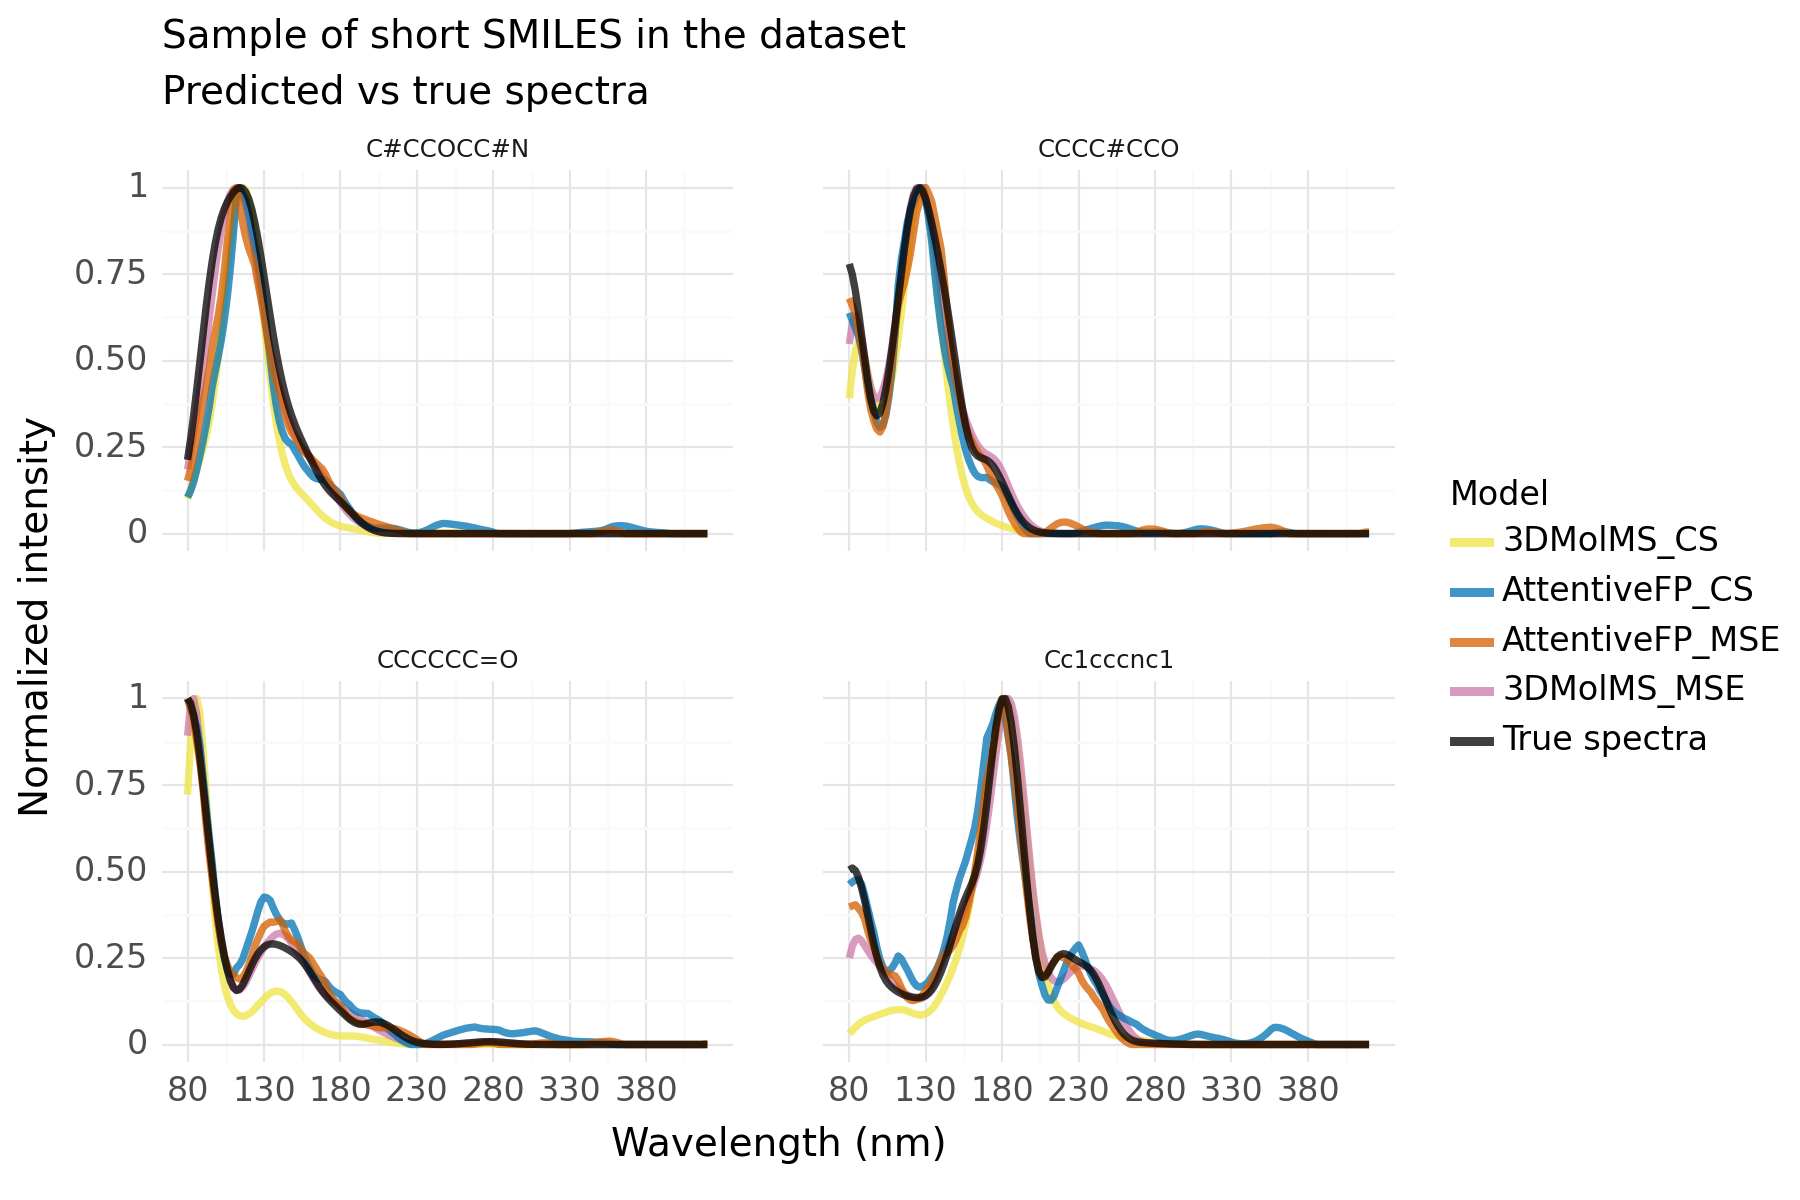

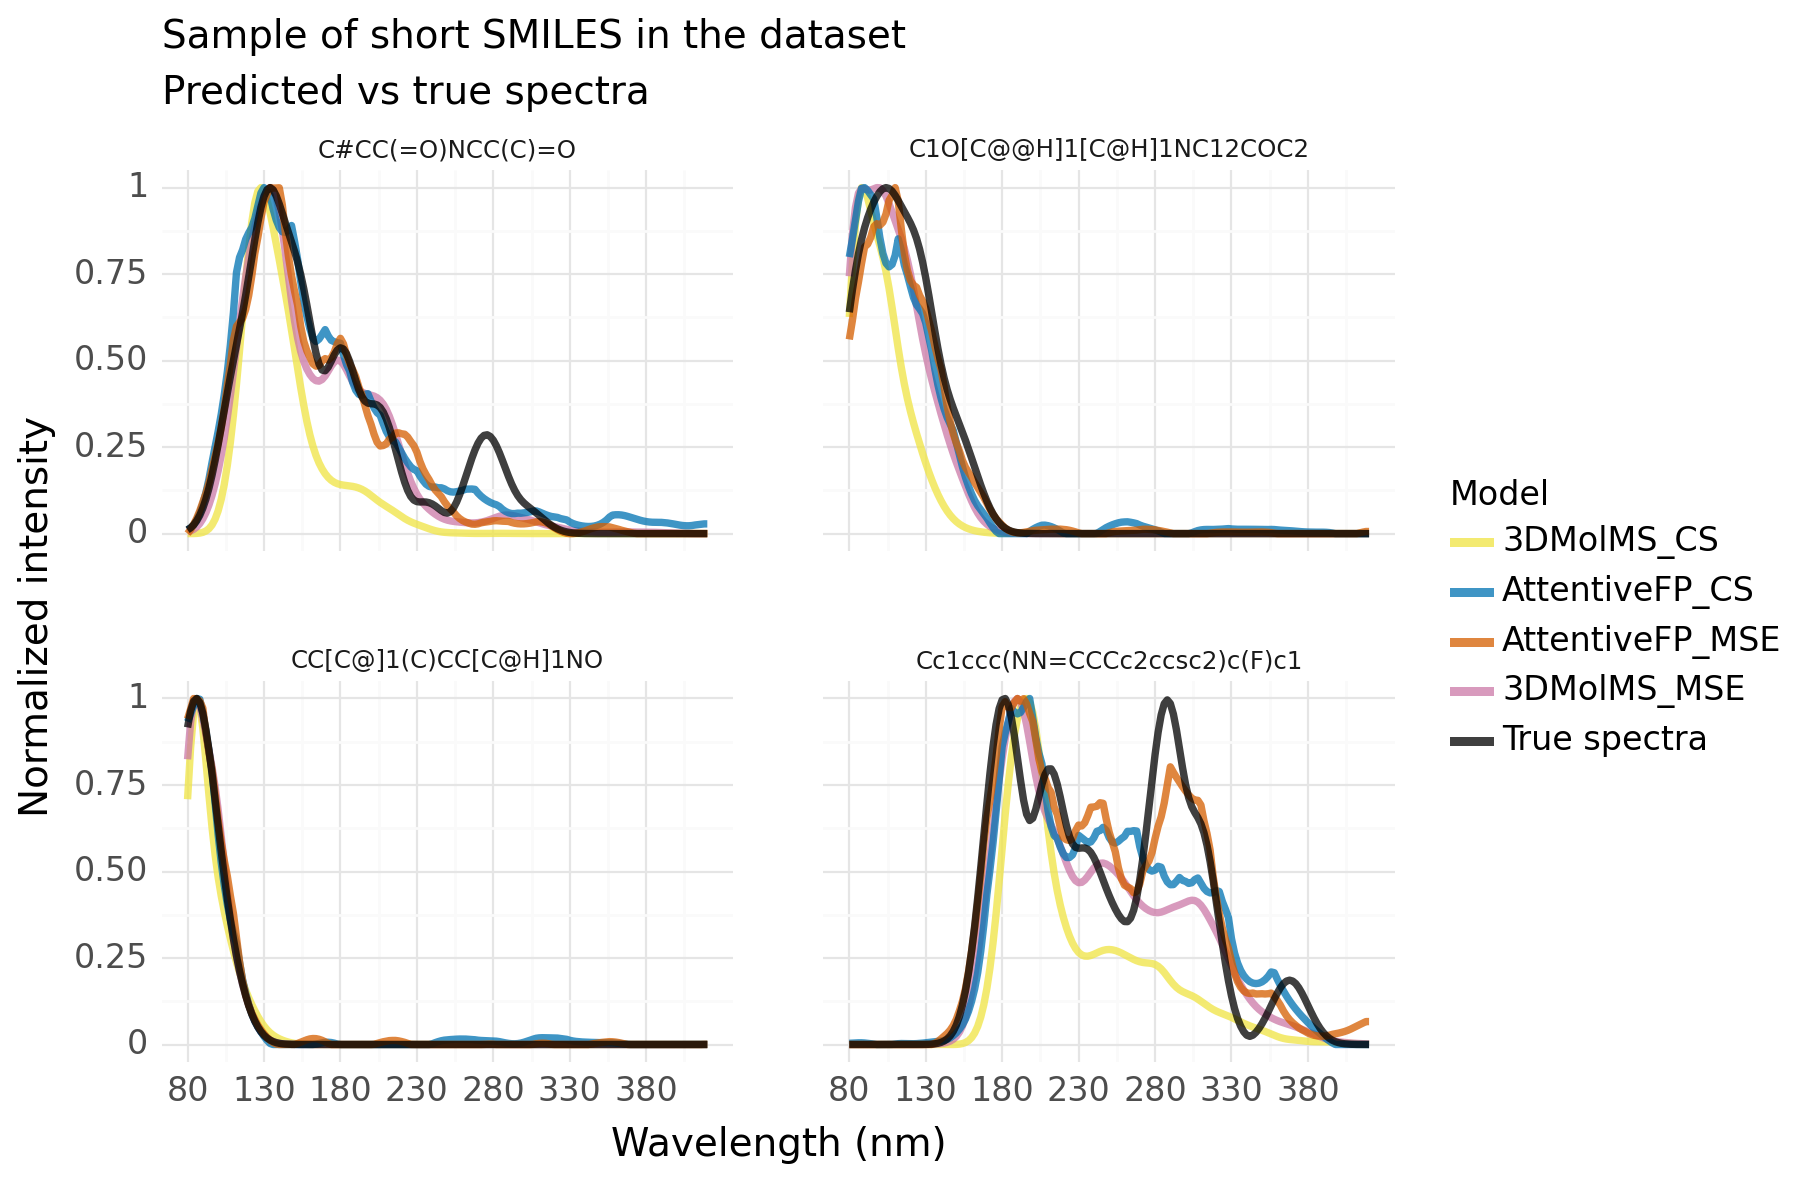

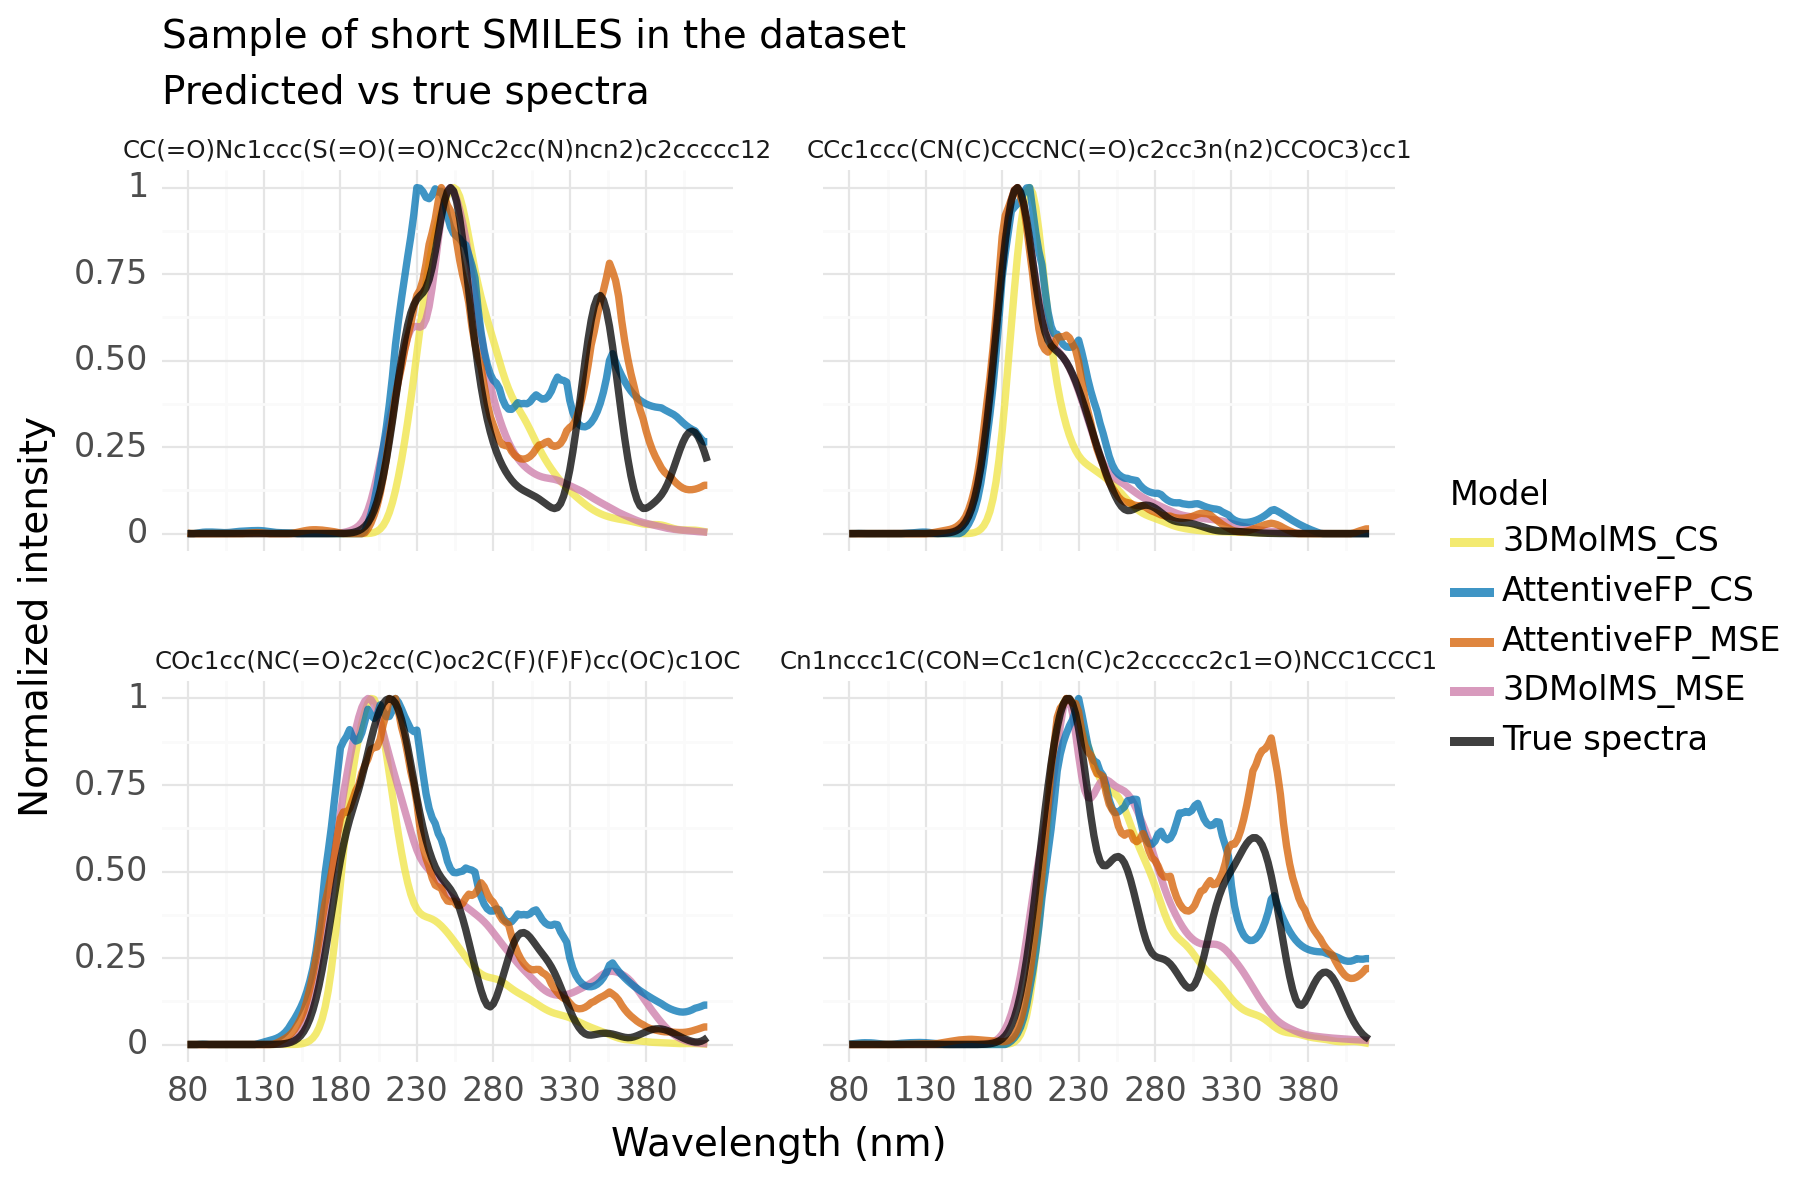

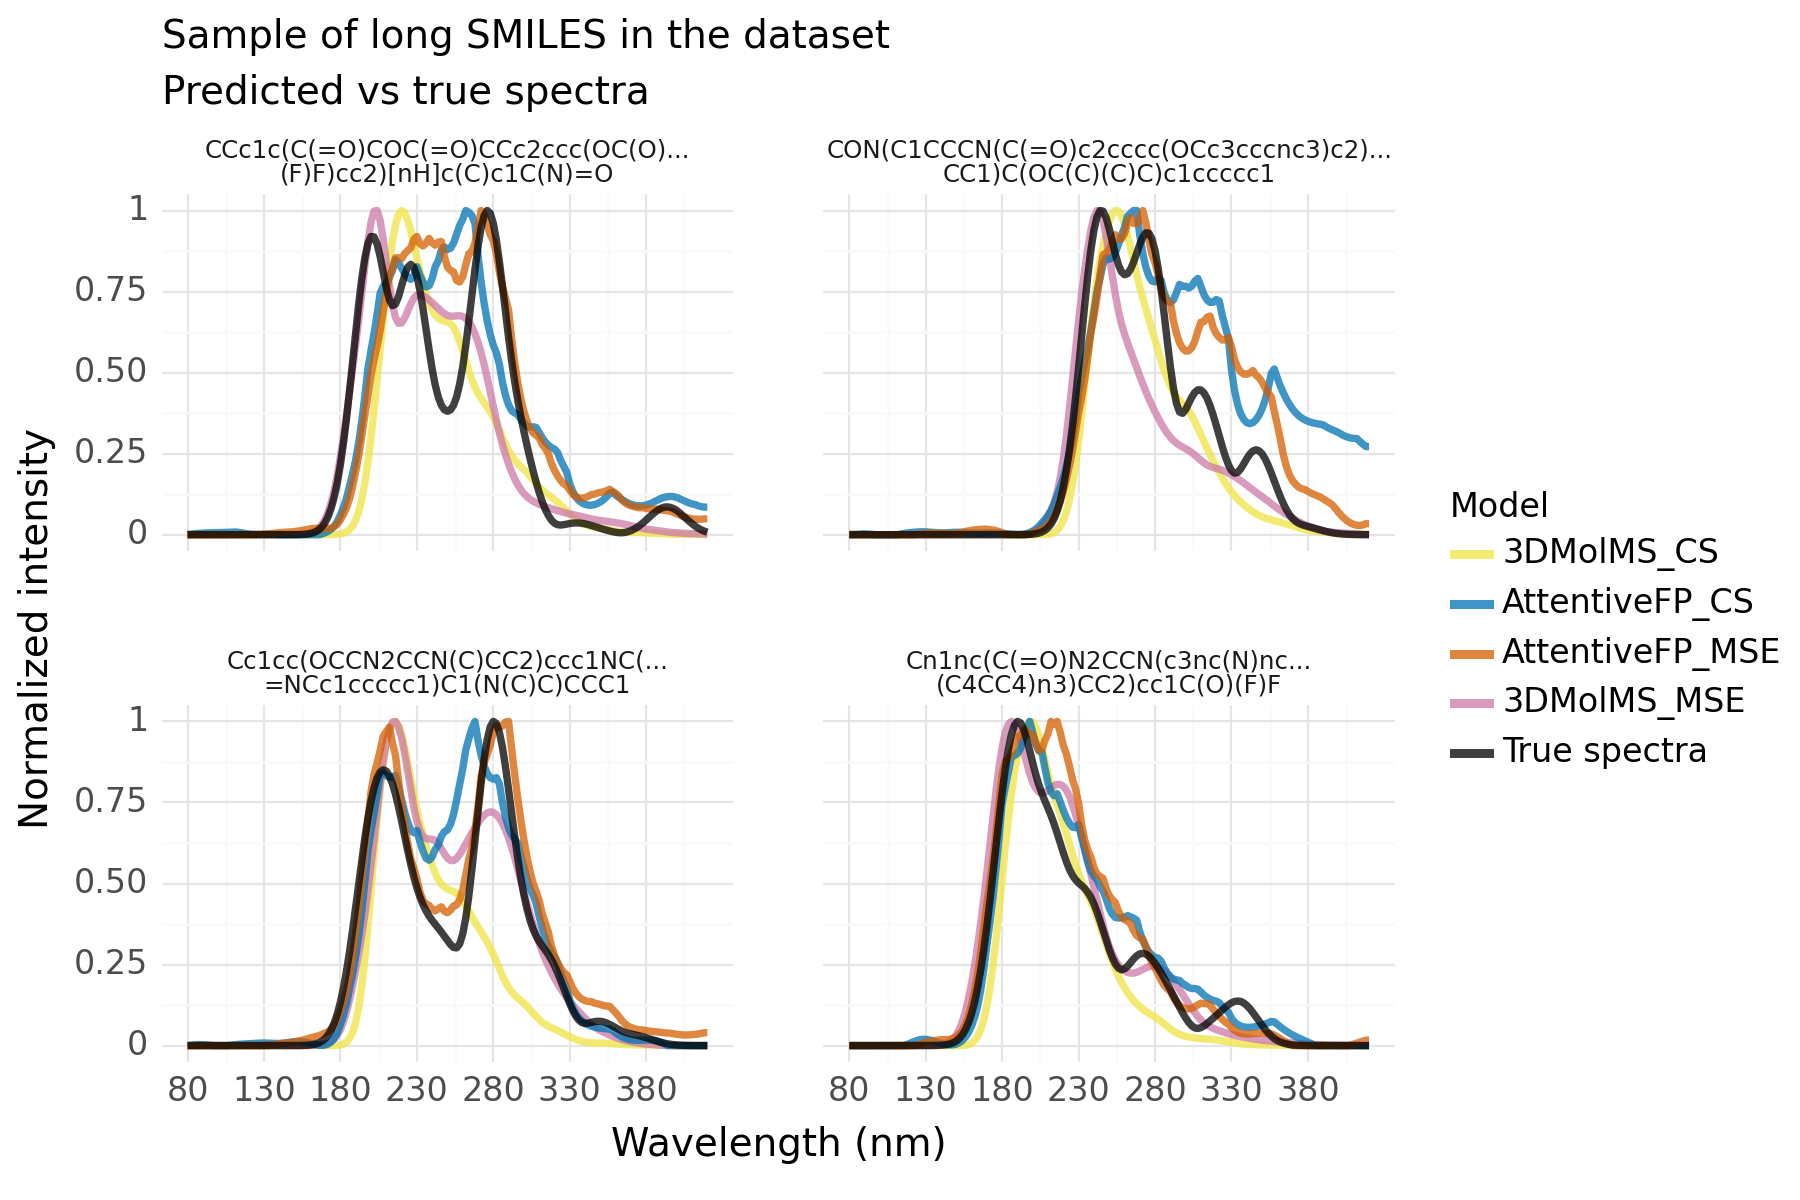

[<Figure Size: (900 x 600)>,
 <Figure Size: (900 x 600)>,
 <Figure Size: (900 x 600)>,
 <Figure Size: (900 x 600)>]

In [19]:
def custom_labeller(s):
    # Define your custom labels here
    return {'Cn1nc(C(=O)N2CCN(c3nc(N)nc(C4CC4)n3)CC2)cc1C(O)(F)F':'Cn1nc(C(=O)N2CCN(c3nc(N)nc...\n(C4CC4)n3)CC2)cc1C(O)(F)F',
            'Cc1cc(OCCN2CCN(C)CC2)ccc1NC(=NCc1ccccc1)C1(N(C)C)CCC1':'Cc1cc(OCCN2CCN(C)CC2)ccc1NC(...\n=NCc1ccccc1)C1(N(C)C)CCC1',
            'CCc1c(C(=O)COC(=O)CCc2ccc(OC(O)(F)F)cc2)[nH]c(C)c1C(N)=O': 'CCc1c(C(=O)COC(=O)CCc2ccc(OC(O)...\n(F)F)cc2)[nH]c(C)c1C(N)=O',
            'CON(C1CCCN(C(=O)c2cccc(OCc3cccnc3)c2)CC1)C(OC(C)(C)C)c1ccccc1':'CON(C1CCCN(C(=O)c2cccc(OCc3cccnc3)c2)...\nCC1)C(OC(C)(C)C)c1ccccc1'}[s]


import time

# Make a facet plot of the pred kurve for 10 random smiles for each model
# Make a list of 10 random smiles
# Remove entries with dataset = train
df_unique = df.drop(df[df['dataset'] == 'train'].index)

smiles_vec = df_unique['smiles'].unique()
print(len(smiles_vec))
# Order smells_vec based on the length of the smiles
smiles_vec = sorted(smiles_vec, key=len)

plot_groups = [[1,2, 5, 7], [300, 600, 900, 1200], [4000,4500, 5000, 5500], [8000,8500, 9000, 9500]]
#smiles_vec = np.random.choice(smiles_vec, 4)
plots = []
for plot_group in plot_groups:
    smiles_vec_plot = [smiles_vec[i] for i in plot_group]
    # Query df for the smiles in smiles_vec
    df_plot = df.query('smiles in @smiles_vec_plot')
    df_plot['pred'] = df_plot.groupby('group_id')['pred'].transform(lambda x: x/x.max())
    #df_plot['pred'] = df_plot.groupby(['group_id'])['pred'].transform(lambda x: x/x.max())
    df_true = df_plot.query("model == '3DMolMS_CS'")
    df_true['pred'] = df_true['y']
    # Change model name in df_true to 'True spectra'
    df_true['model'] = 'True spectra'
    # Change group_id in df_true to 'True_spectra'+smiles
    df_true['group_id'] = 'True_spectra' + '_' + df_true['smiles']
    # Concat df_true and df_plot
    df_plot = pd.concat([df_true, df_plot])
    order = ['3DMolMS_CS', 'AttentiveFP_CS', 'AttentiveFP_MSE', '3DMolMS_MSE', 'True spectra']
    # Change order of models in df_plot
    df_plot['model'] = pd.Categorical(df_plot['model'], order)


    # Add a new column to your DataFrame for the color of the line
    if plot_group == plot_groups[-1]:
        print(smiles_vec_plot)
        p = (ggplot(df_plot, aes('nm', 'pred', group='group_id', color='model'))
        + geom_line(size=1.5, alpha=0.75)
        # Change colors 
        + scale_color_manual(values=[cbPalette[6], cbPalette[3], cbPalette[4], cbPalette[5], 'black'])
        + facet_wrap('~smiles',  labeller=custom_labeller)
        
        + labs(y = 'Normalized intensity', x = 'Wavelength (nm)', title='Sample of long SMILES in the dataset', subtitle='Predicted vs true spectra')
        + scale_x_continuous(breaks=range(80, 420, 50), lims=(80, 420))
        + labs(color='Model')
        + theme_minimal()
        + theme(title=element_text(size=14),
                axis_title=element_text(size=14),
                axis_text=element_text(size=12),
                legend_title=element_text(size=12),
                legend_text=element_text(size=12))
        + theme(figure_size=(9, 6), panel_spacing = 0.05)  # Increase the space between the plots
    )
        
    else:
        p = (ggplot(df_plot, aes('nm', 'pred', group='group_id', color='model'))
            + geom_line(size=1.5, alpha=0.75)
            # Change colors 
            + scale_color_manual(values=[cbPalette[6], cbPalette[3], cbPalette[4], cbPalette[5], 'black'])
            + facet_wrap('~smiles')
            
            + labs(y = 'Normalized intensity', x = 'Wavelength (nm)', title='Sample of short SMILES in the dataset', subtitle='Predicted vs true spectra')
            + scale_x_continuous(breaks=range(80, 420, 50), lims=(80, 420))
            + labs(color='Model')
            + theme_minimal()
            #Increase all fontsizes with 2
            + theme(title=element_text(size=14),
                    axis_title=element_text(size=14),
                    axis_text=element_text(size=12),
                    legend_title=element_text(size=12),
                    legend_text=element_text(size=12))
            + theme(figure_size=(9, 6), panel_spacing = 0.05)  # Increase the space between the plots
        )
    plots.append(p)

plots



9701


/tmp/ipykernel_13733/1950718157.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_13733/1950718157.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_13733/1950718157.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_1373

['Cc1ccsc1-c1nc(C=N)c(N2CCN(C(=O)COC(=O)C(C)(C)N3CCCC3)CC2)o1', 'CNS(=O)(=O)c1cc2c(nc1C)CCN(C(=O)c1cnc(O)cc1C(F)(F)F)C2', 'C=CCn1cc2ccc(NC(=O)C3=C(c4ccc(OC)nc4)C=NNN=C3)cc2n1', 'CC1(C)Cc2cc(COC(=O)c3ccc(Nc4ccccc4)nc3C(F)(F)F)ccc2O1']


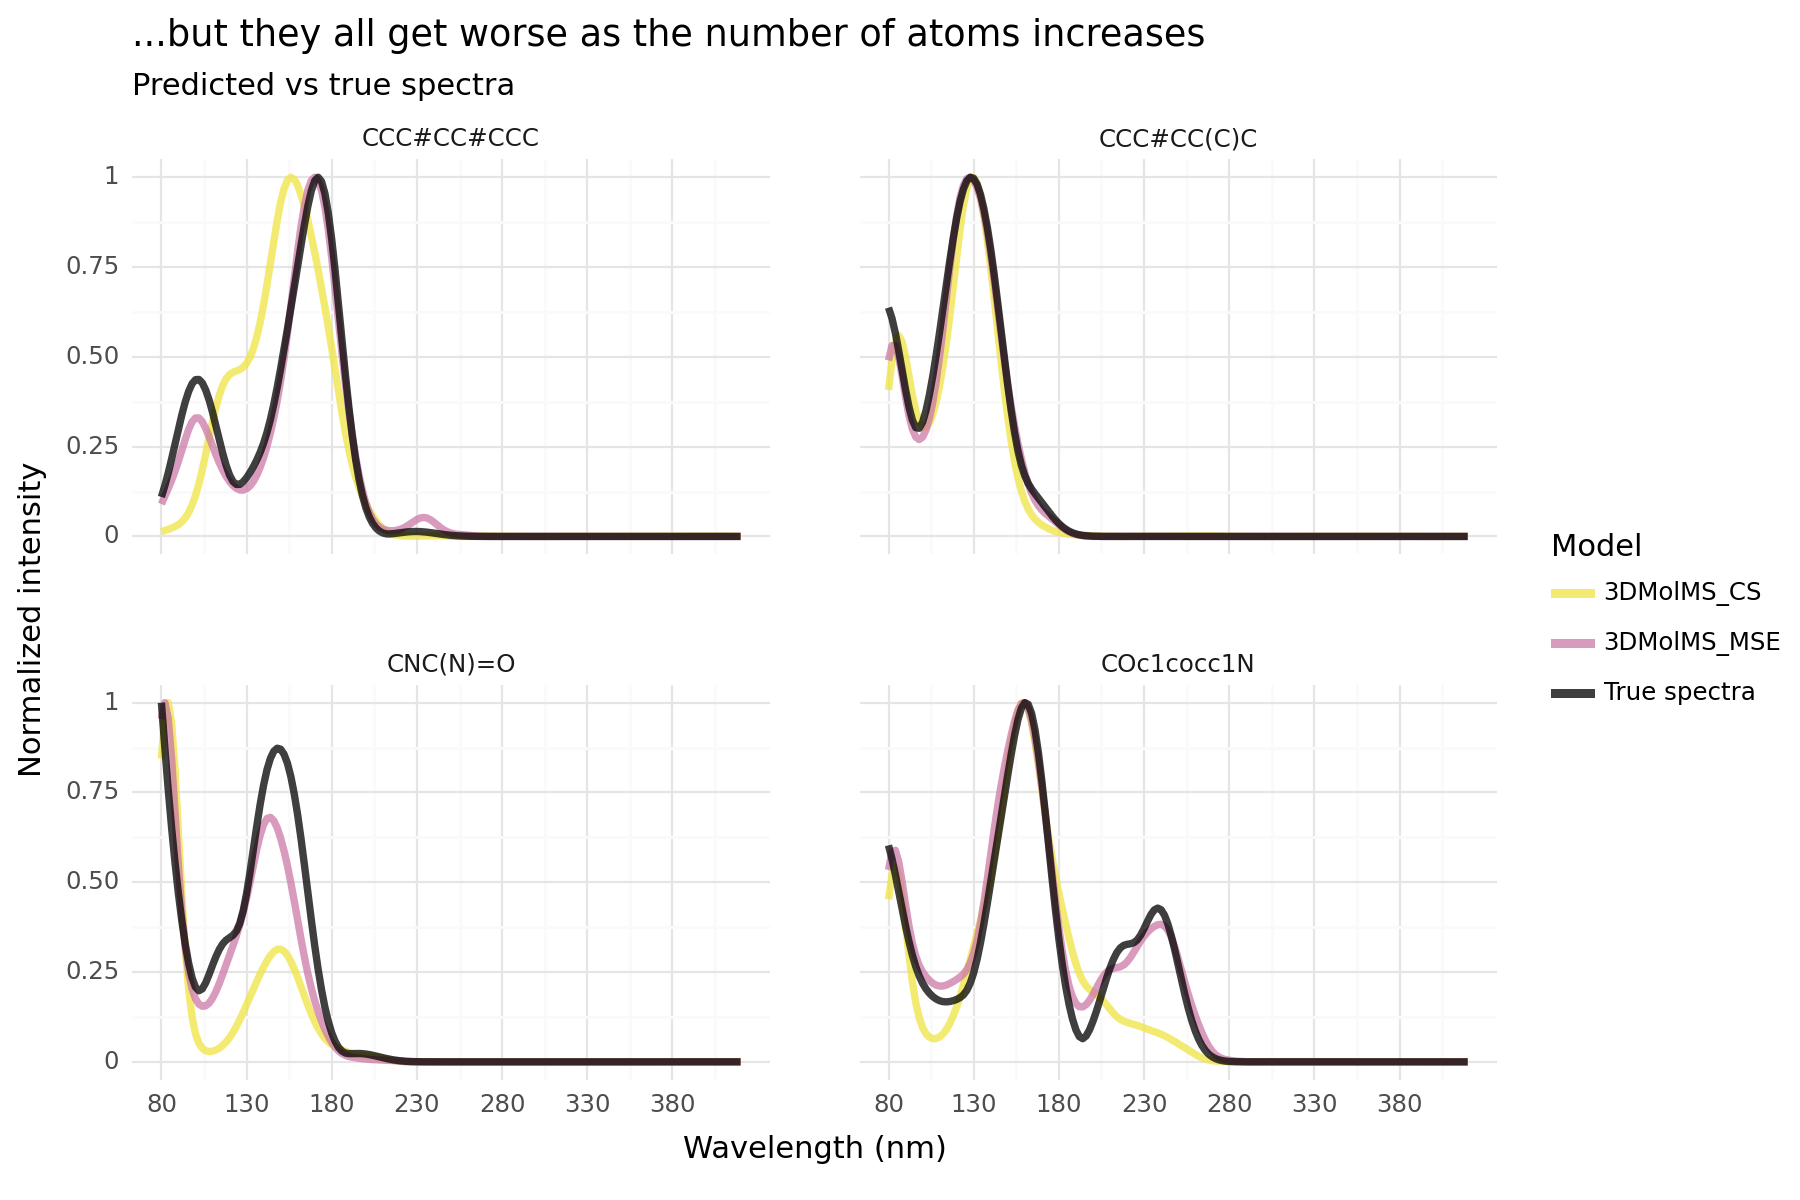

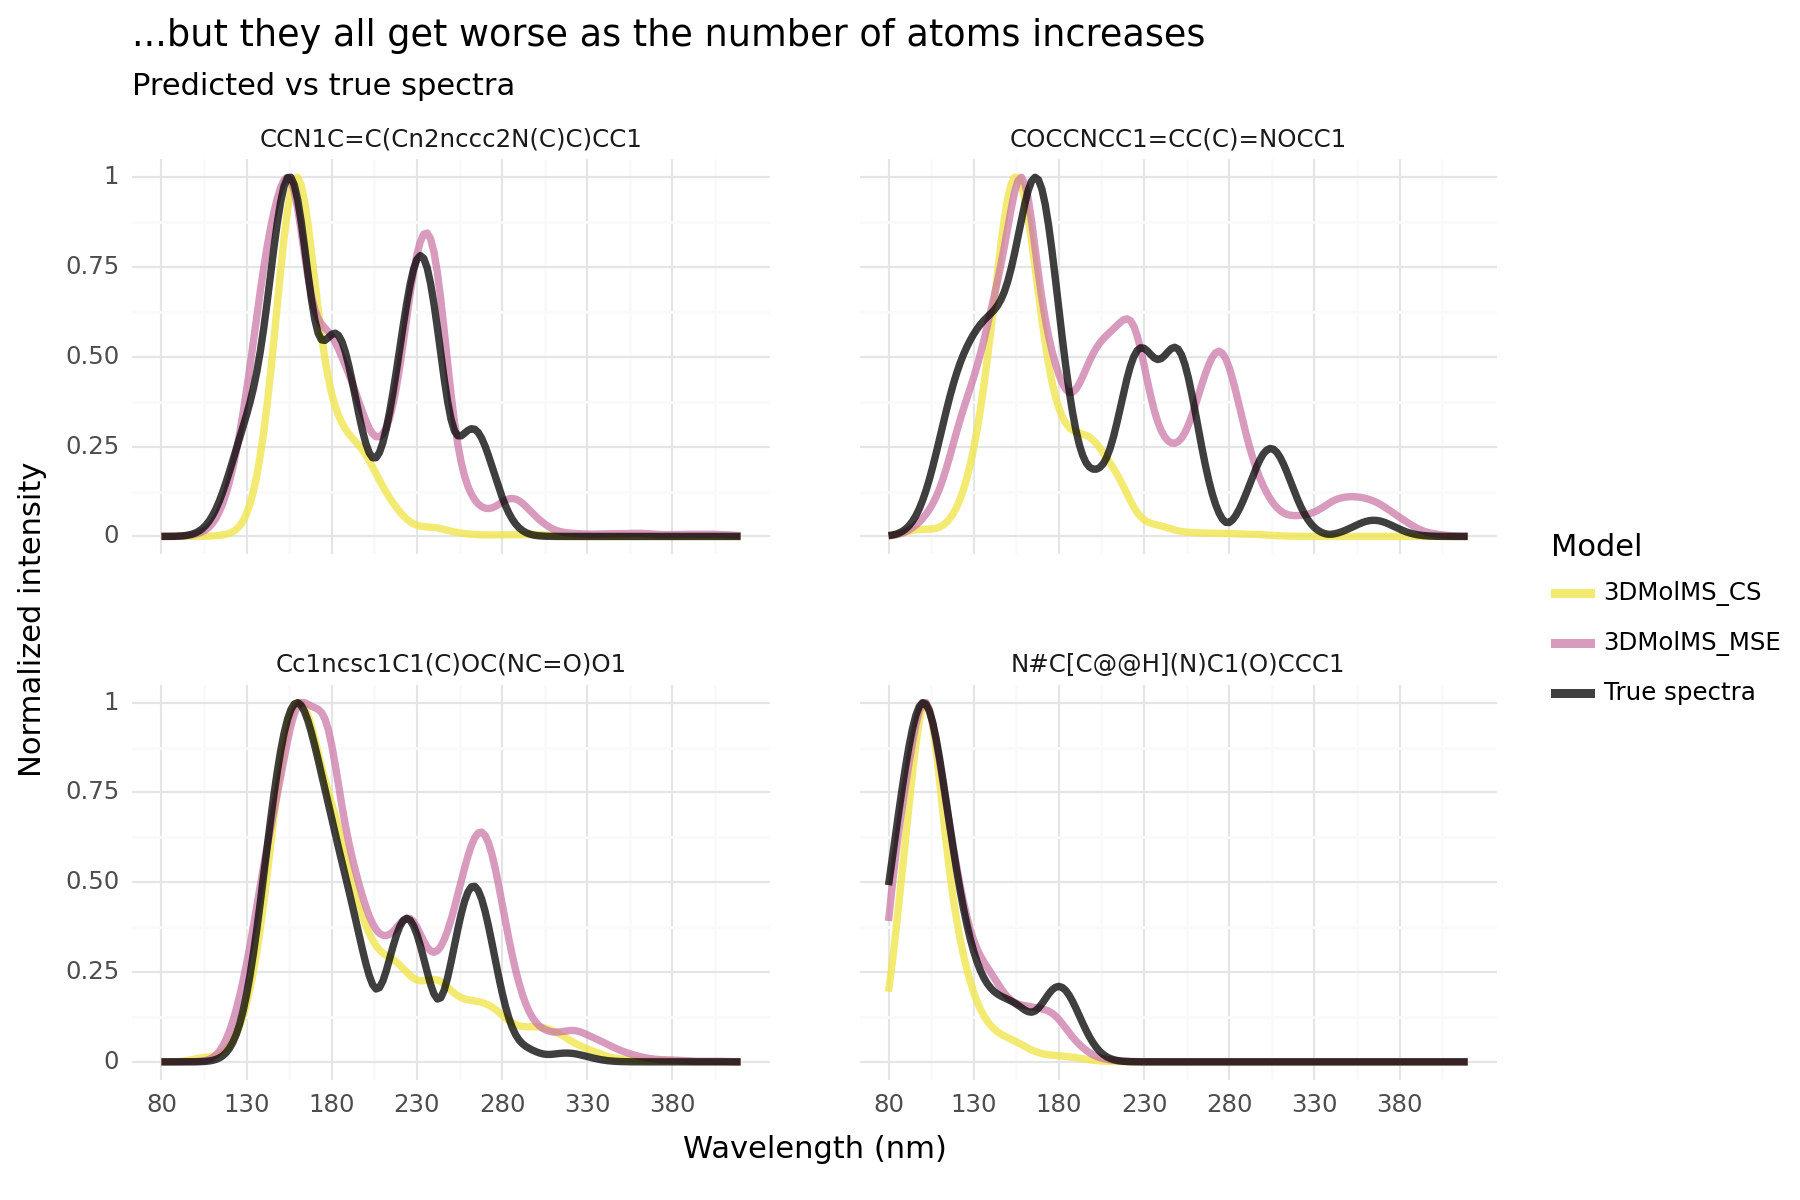

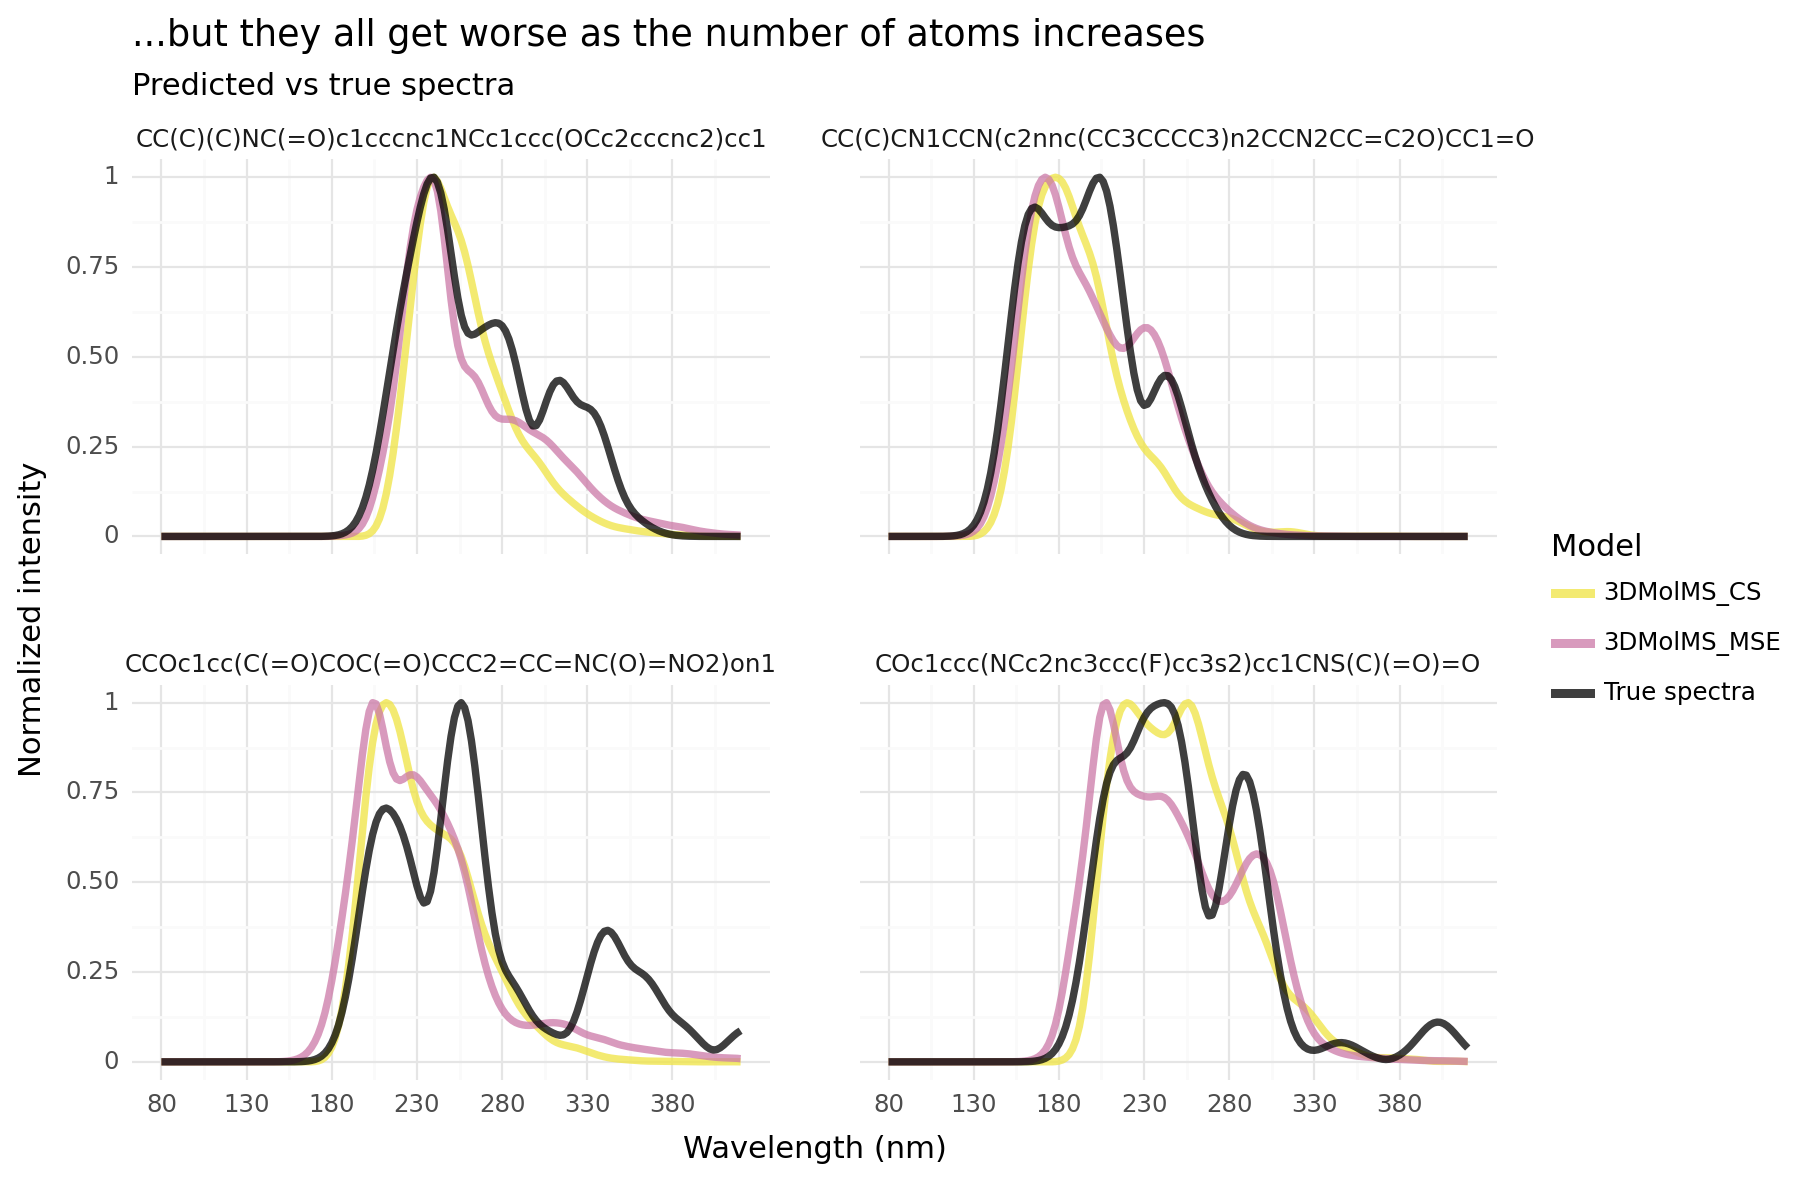

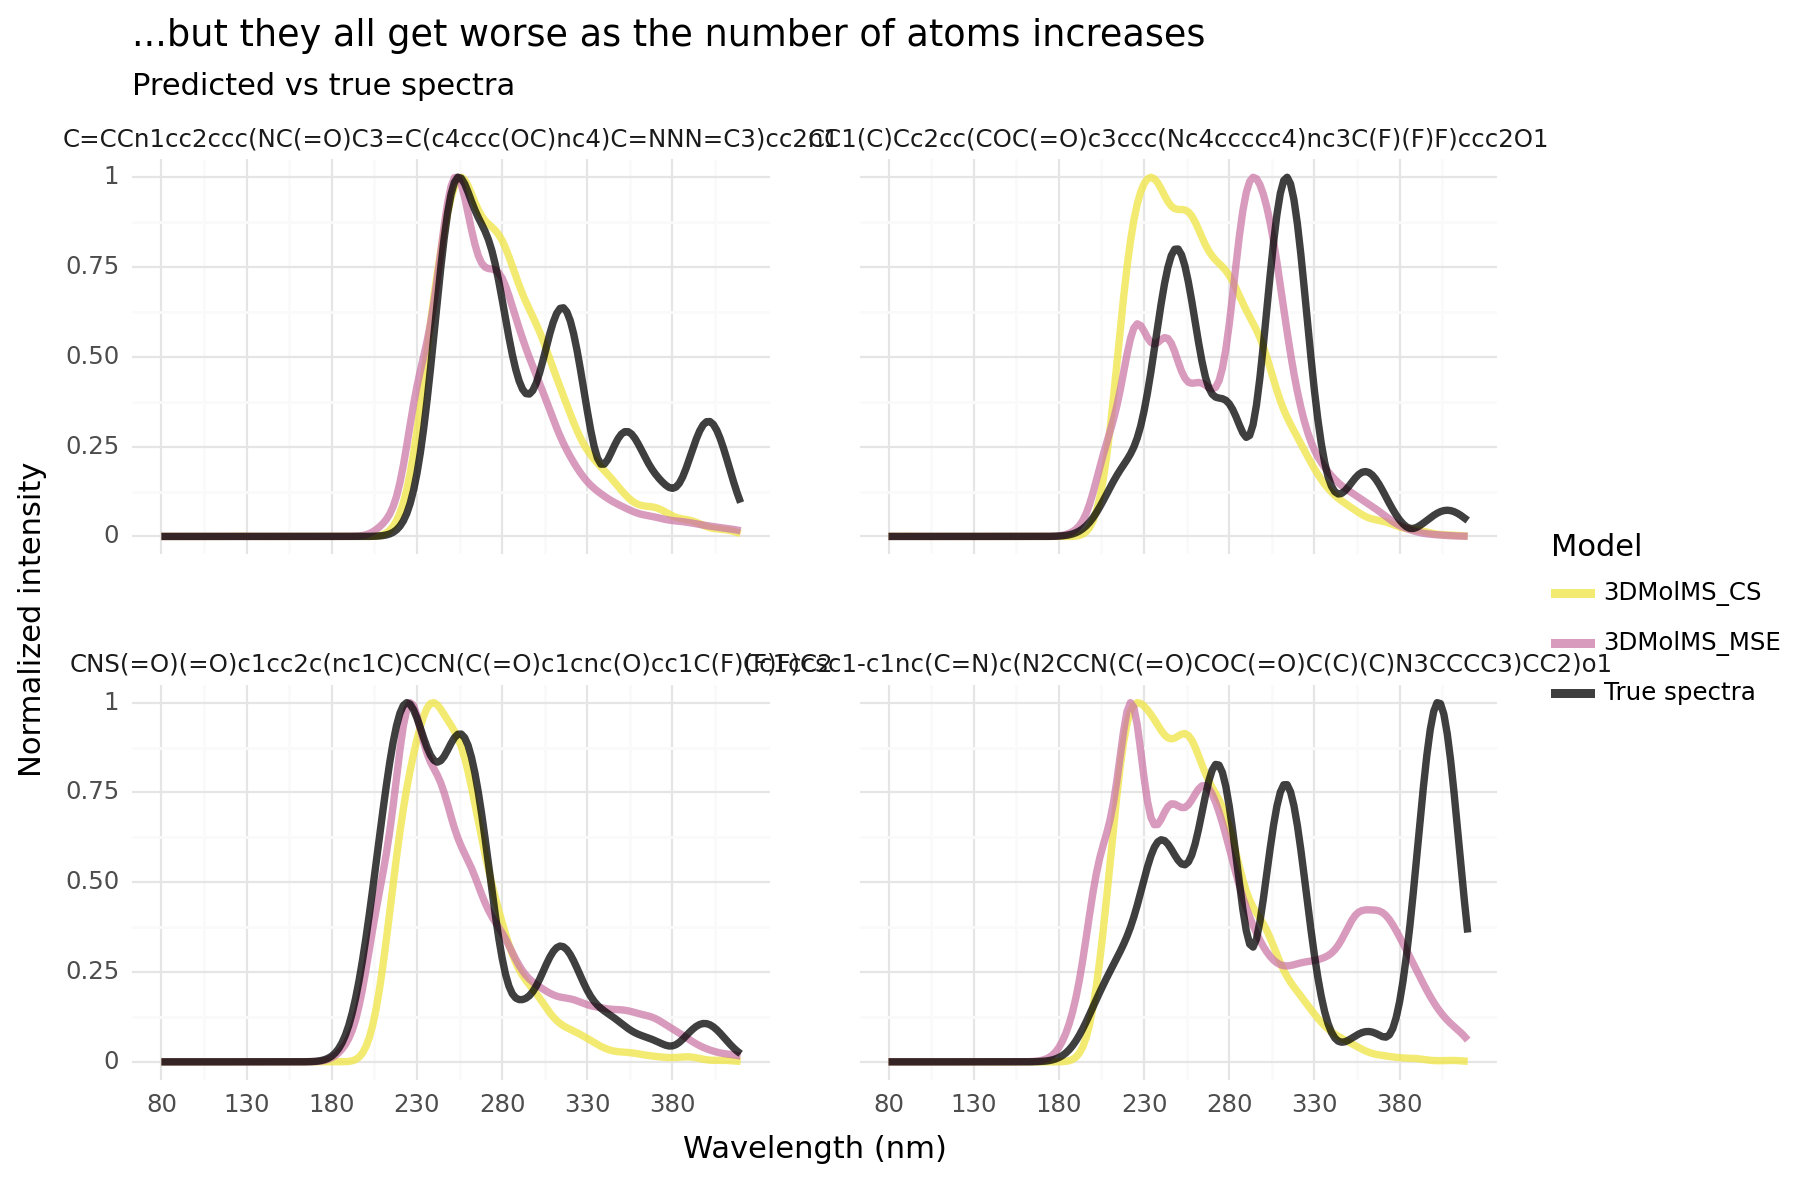

[<Figure Size: (900 x 600)>,
 <Figure Size: (900 x 600)>,
 <Figure Size: (900 x 600)>,
 <Figure Size: (900 x 600)>]

In [130]:
def custom_labeller(s):
    # Define your custom labels here
    return {'Cn1nc(C(=O)N2CCN(c3nc(N)nc(C4CC4)n3)CC2)cc1C(O)(F)F':'Cn1nc(C(=O)N2CCN(c3nc(N)nc...\n(C4CC4)n3)CC2)cc1C(O)(F)F',
            'Cc1cc(OCCN2CCN(C)CC2)ccc1NC(=NCc1ccccc1)C1(N(C)C)CCC1':'Cc1cc(OCCN2CCN(C)CC2)ccc1NC(...\n=NCc1ccccc1)C1(N(C)C)CCC1',
            'CCc1c(C(=O)COC(=O)CCc2ccc(OC(O)(F)F)cc2)[nH]c(C)c1C(N)=O': 'CCc1c(C(=O)COC(=O)CCc2ccc(OC(O)...\n(F)F)cc2)[nH]c(C)c1C(N)=O',
            'CON(C1CCCN(C(=O)c2cccc(OCc3cccnc3)c2)CC1)C(OC(C)(C)C)c1ccccc1':'CON(C1CCCN(C(=O)c2cccc(OCc3cccnc3)c2)...\nCC1)C(OC(C)(C)C)c1ccccc1'}[s]


import time

cbPalette = ["#E69F00", "#56B4E9", "#009E73", 
             "#0072B2", "#D55E00", 
             "#CC79A7", "#F0E442", "#999999"]

df = pd.read_pickle(main_data_path)

# Make a facet plot of the pred kurve for 10 random smiles for each model
# Make a list of 10 random smiles
# Remove entries with dataset = train
df_unique = df.drop(df[df['dataset'] == 'validation'].index)
df_unique = df.drop(df[df['dataset'] == 'train'].index)





smiles_vec = df_unique['smiles'].unique()
print(len(smiles_vec))
# Order smells_vec based on the length of the smiles
smiles_vec = sorted(smiles_vec, key=len)

#plot_groups = [[1,2, 5, 7], [300, 600, 900, 1200], [4000,4500, 5000, 5500], [8000,8500, 9000, 9500]]
#Generate a random sample of 4 numbers 4 times in 4 different ranges in for lists
plot_groups = []

plot_groups.append(list(np.random.choice(range(0, 25), 4, replace=False)))
plot_groups.append(list(np.random.choice(range(300, 1200), 4, replace=False)))
plot_groups.append(list(np.random.choice(range(3000, 6000), 4, replace=False)))
plot_groups.append(list(np.random.choice(range(7500, 9500), 4, replace=False)))
#smiles_vec = np.random.choice(smiles_vec, 4)
plots = []
for plot_group in plot_groups:
    smiles_vec_plot = [smiles_vec[i] for i in plot_group]
    # Query df for the smiles in smiles_vec
    df_plot = df.query('smiles in @smiles_vec_plot')
    df_plot['pred'] = df_plot.groupby('group_id')['pred'].transform(lambda x: x/x.max())
    #df_plot['pred'] = df_plot.groupby(['group_id'])['pred'].transform(lambda x: x/x.max())
    df_true = df_plot.query("model == '3DMolMS_CS'")
    df_true['pred'] = df_true['y']
    # Change model name in df_true to 'True spectra'
    df_true['model'] = 'True spectra'
    # Change group_id in df_true to 'True_spectra'+smiles
    df_true['group_id'] = 'True_spectra' + '_' + df_true['smiles']
    # Concat df_true and df_plot
    df_plot = pd.concat([df_true, df_plot])
    order = ['3DMolMS_CS', '3DMolMS_MSE', 'True spectra']
    # Change order of models in df_plot
    df_plot['model'] = pd.Categorical(df_plot['model'], order)


    # Add a new column to your DataFrame for the color of the line
    if plot_group == plot_groups[-1]:
        print(smiles_vec_plot)
        p = (ggplot(df_plot, aes('nm', 'pred', group='group_id', color='model'))
        + geom_line(size=1.5, alpha=0.75)
        # Change colors 
        + scale_color_manual(values=[cbPalette[6], cbPalette[5], 'black'])
        + facet_wrap('~smiles')#,  labeller=custom_labeller)
        
        + labs(y = 'Normalized intensity', x = 'Wavelength (nm)', title='...but they all get worse as the number of atoms increases', subtitle='Predicted vs true spectra')
        + scale_x_continuous(breaks=range(80, 420, 50), lims=(80, 420))
        + labs(color='Model')
        + theme_minimal()
        + theme(figure_size=(9, 6), panel_spacing = 0.05)  # Increase the space between the plots
        )
        
    else:
        p = (ggplot(df_plot, aes('nm', 'pred', group='group_id', color='model'))
            + geom_line(size=1.5, alpha=0.75)
            # Change colors 
            + scale_color_manual(values=[cbPalette[6], cbPalette[5], 'black'])
            + facet_wrap('~smiles')
            
            + labs(y = 'Normalized intensity', x = 'Wavelength (nm)', title='...but they all get worse as the number of atoms increases', subtitle='Predicted vs true spectra')
            + scale_x_continuous(breaks=range(80, 420, 50), lims=(80, 420))
            + labs(color='Model')
            + theme_minimal()
            + theme(figure_size=(9, 6), panel_spacing = 0.05)  # Increase the space between the plots
        )
    plots.append(p)

plots

In [ ]:
import csv
# Save the plot_groups to a file by opening a new csv file if it does not exist
if not os.path.isfile('plot_groups.csv'):
    with open('plot_groups.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerows(plot_groups)
# Else append to it by staring on a new line
else:
    with open('plot_groups.csv', 'a') as f:
        writer = csv.writer(f)
        # Add an additional empty line
        writer.writerow([])
        writer.writerows(plot_groups)
        
        

/home/nyrenw/anaconda3/envs/MVE080/lib/python3.11/site-packages/plotnine/scales/scale.py:143: PlotnineWarning: scale_x_continuous could not recognise parameter `lims`


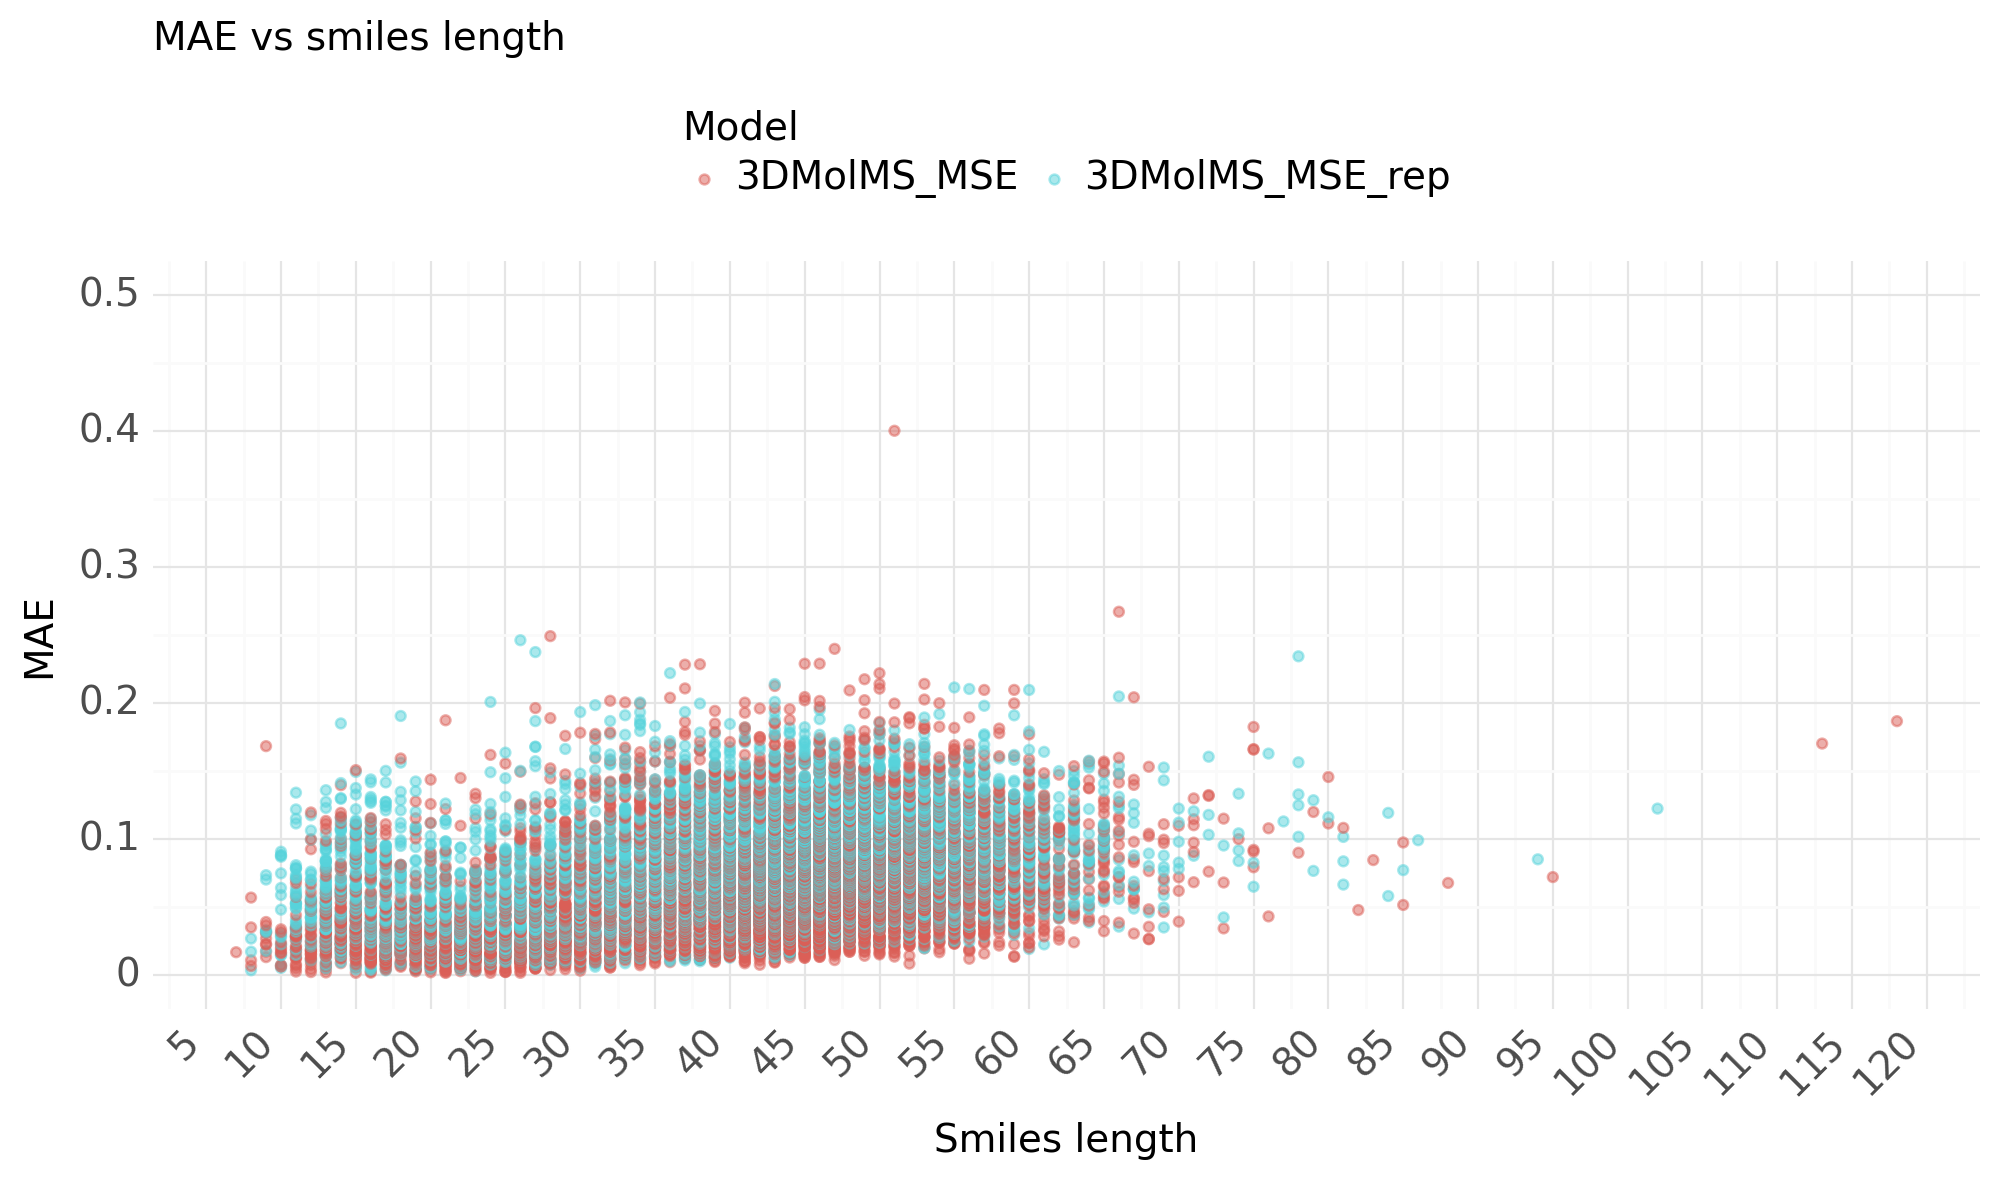

<Figure Size: (1000 x 600)>

In [152]:

cbPalette = ["#E69F00", "#56B4E9", "#009E73", 
             "#0072B2", "#D55E00", 
             "#CC79A7", "#F0E442", "#999999"]

df_main = pd.read_pickle(main_data_path)

# Drop model = 3DMolMS_CS
#df = df.drop(df[df['model'] == '3DMolMS_MSE_rep'].index)
df = df_main.drop(df_main[df_main['model'] == '3DMolMS_CS'].index)


# Make a facet plot of the pred kurve for 10 random smiles for each model
# Make a list of 10 random smiles
# Remove entries with dataset = train

# Sort dataframe by MAE and group_id
df = df.sort_values(by=['MAE', 'group_id'])
# Drop duplicates based on group_id
df = df.drop_duplicates(subset='group_id')
# Add a variable with the length of the smiles
df['smiles_len'] = df['smiles'].apply(lambda x: len(x))
# Sort dataframe by smiles_len and MAE
df = df.sort_values(by=['smiles_len', 'MAE'])

# Plot smiles_len vs MAE with fitted lines for each model
p = (ggplot(df, aes('smiles_len', 'MAE', color='model'))
     + geom_point(alpha=0.5)
     + labs(y = 'MAE', x = 'Smiles length', title='MAE vs smiles length')
     + scale_x_continuous(breaks=range(0, 140, 5), lims=(0, 140))
     + labs(color='Model')
     # Set x limits to 0 and 140
     + ylim(0, 0.5)
     # Add more ticks on the y-axis and x-axis     
     + theme_minimal()
     # Put lengend on top
     + theme(legend_position='top')
     # Tilt the x-axis labels 45 degrees
     + theme(axis_text_x=element_text(rotation=45, hjust=1))
     # Increase text size
     + theme(text=element_text(size=14))
     + theme(figure_size=(10, 6))  # Increase the space between the plots
)
p



In [156]:
from scipy.signal import find_peaks


df_main['smiles_len'] = df_main['smiles'].apply(lambda x: len(x))


In [157]:
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.Fingerprints import FingerprintMols


In [158]:
def get_mol_sim(df_smiles):
    c_smiles = []
    for ds in df_smiles:
        try:
            cs = Chem.CanonSmiles(ds)
            c_smiles.append(cs)
        except:
            print('Invalid SMILES:', ds)
    print()

    # make a list of mols
    ms = [Chem.MolFromSmiles(x) for x in c_smiles]

    # make a list of fingerprints (fp)
    fps = [AllChem.GetMorganFingerprintAsBitVect(x, 2, nBits=1024) for x in ms]  
    # the list for the dataframe
    qu, ta, sim = [], [], []

    # compare all fp pairwise without duplicates
    for n in range(len(fps)-1): # -1 so the last fp will not be used
        s = DataStructs.BulkTanimotoSimilarity(fps[n], fps[n+1:]) # +1 compare with the next to the last fp
        #print(c_smiles[n], c_smiles[n+1:]) # witch mol is compared with what group
        # collect the SMILES and values
        for m in range(len(s)):
            qu.append(c_smiles[n])
            ta.append(c_smiles[n+1:][m])
            sim.append(s[m])
    print()

    d = {'query':qu, 'target':ta, 'Similarity':sim}
    df_final = pd.DataFrame(data=d)
    df_final = df_final.sort_values('Similarity', ascending=False)
    #Print the median of the simularity
    #print(df_final['Similarity'].median())
    #print the mean of the simularity
    #print(df_final['Similarity'].mean())
    #print the std of the simularity
    #print(df_final['Similarity'].std())
    return df_final



['3DMolMS_MSE_C=C(NCc1ccc(O)c(F)c1)C(C)(C)c1ccc(OC)cc1F_MAX']


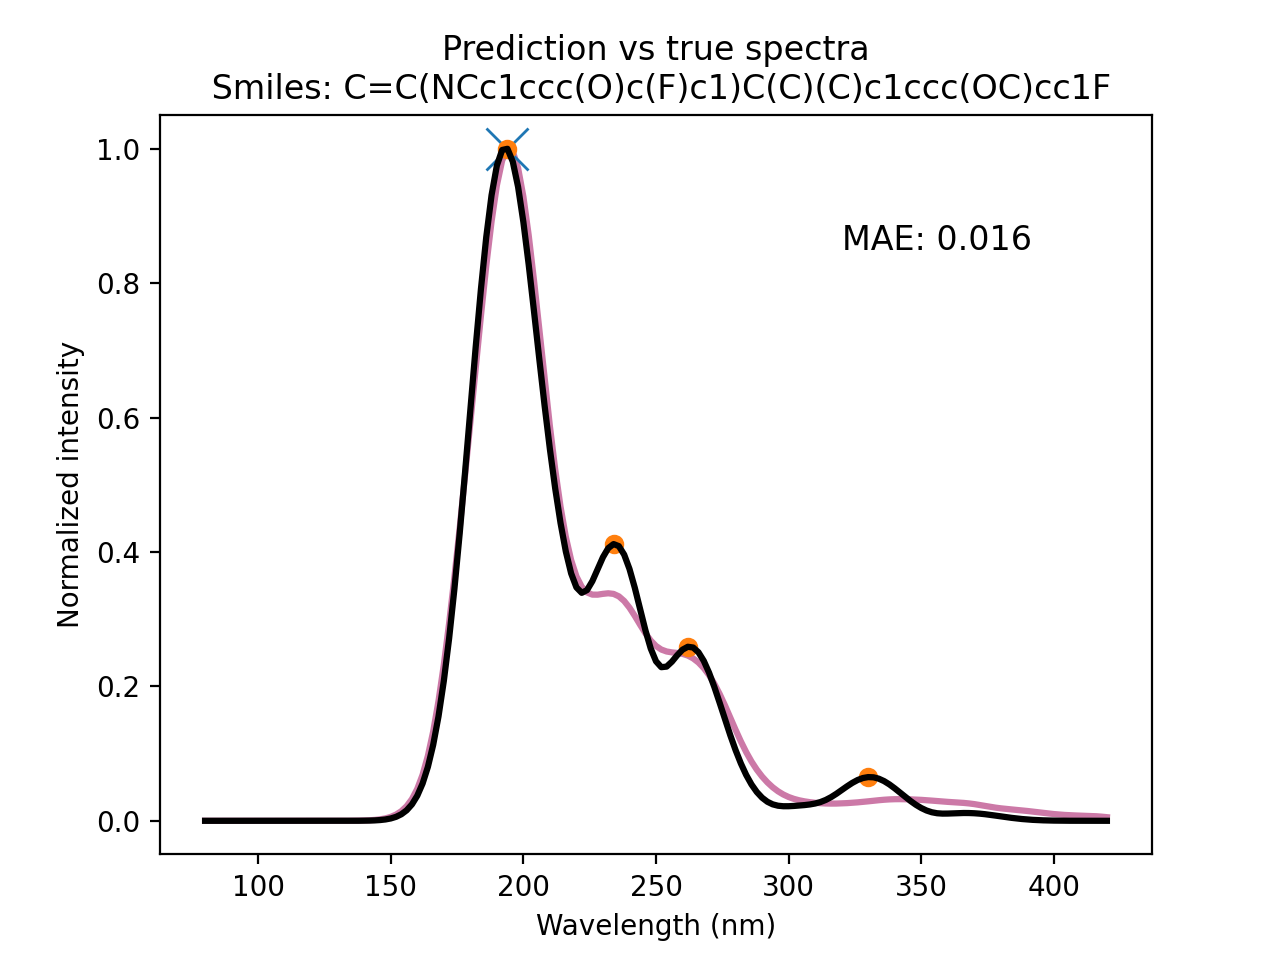

['3DMolMS_MSE_CC(C)(C)CCOc1ccc(CCCC(=O)NCCOC2CCSCC2)cc1_MAX']


['3DMolMS_MSE_CC(C)(F)n1nnnc1CN1CCCC2(CC1)C(F)(F)C2(F)F_MAX']


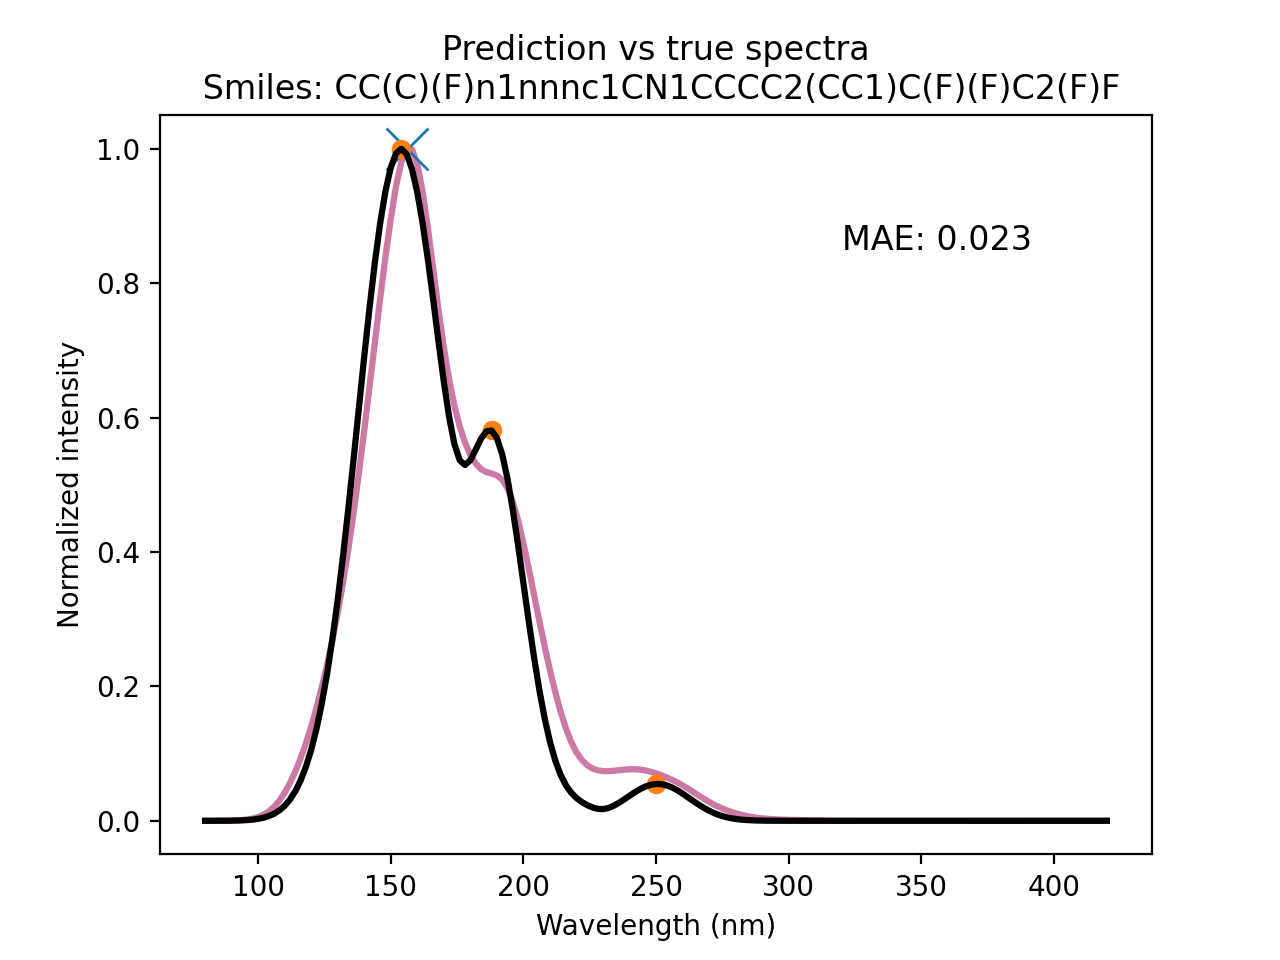

['3DMolMS_MSE_CC(C)CCOc1ccc(C(C)(C)CNC(=O)NC2CCCCC2)cc1_MAX']


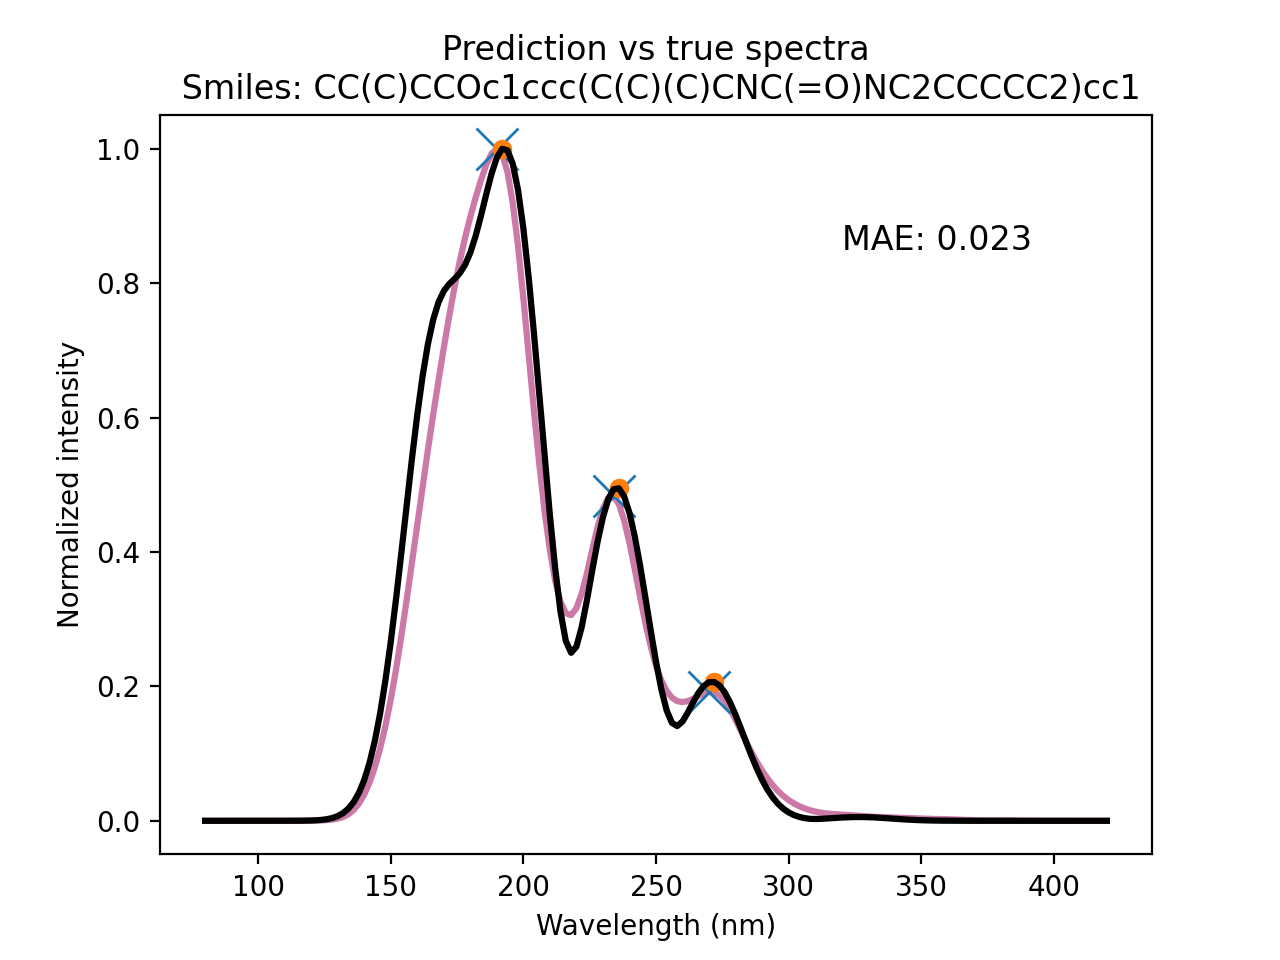

['3DMolMS_MSE_CC(C)c1noc(CN2CC(N(C)CNC(=O)CCC3CC3)C2)n1_MAX']


['3DMolMS_MSE_CC=C(C)CCNC(=NN)NCC1(Oc2ccc(C(C)C)cc2)CC1_MAX']


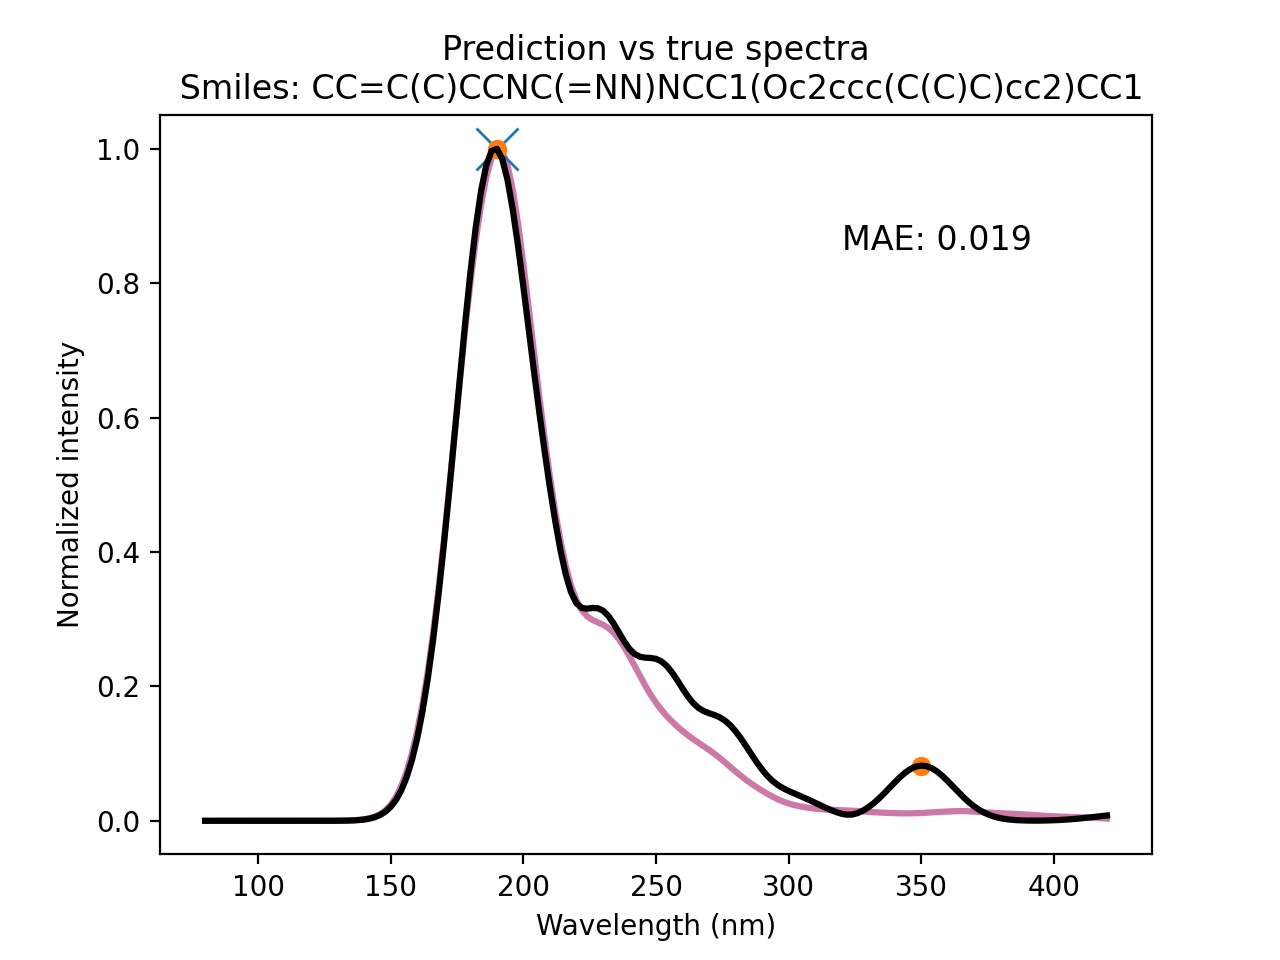

In [174]:


# Filter out the molecules with MAE in the range 0.1 to 0.2 and Number of atoms in molecule in the range 0 to 20
df_subset = df_main.query('MAE > 0.0 and MAE < 0.025 and smiles_len > 40 and smiles_len < 50')
# Remove dataset train
df_subset = df_subset.drop(df_subset[df_subset['dataset'] == 'train'].index)
# Remove model 3DMolMS_CS
df_subset = df_subset.drop(df_subset[df_subset['model'] == '3DMolMS_CS'].index)
# Put unique group_id in a list
a_smiles_vec = df_subset['smiles'].unique()
# Sort smiles_vec based on the length of the smiles
a_smiles_vec = sorted(a_smiles_vec, key=len)
get_mol_sim(a_smiles_vec)
prominence_val = 0.01
x = np.linspace(80, 420, 171)

for idx, smiles in enumerate(a_smiles_vec):
    # Querey df_subset for smiles
    df_subset_tmp = df_subset.query('smiles == @smiles')
    # List all unique group_id in df_subset_tmp
    group_id_vec = df_subset_tmp['group_id'].unique()
    print(group_id_vec)
    
    # Put spectra of current group_id in a numpy array
    spectra_1 = df_subset_tmp[df_subset_tmp['group_id'] == group_id_vec[0]]['pred'].values
    # Find peaks in spectra
    peaks_1, _ = find_peaks(spectra_1, prominence=prominence_val)
    
    # Find the peaks in true spectra
    true_spectra = df_subset[df_subset['group_id'] == group_id_vec[0]]['y'].values
    true_peaks, _ = find_peaks(true_spectra, prominence=prominence_val)
    # Print spectra and mark the peaks
    # Compute MAE
    MAE = df_subset_tmp[df_subset_tmp['group_id'] == group_id_vec[0]]['MAE'].values[0]
    plt.plot(x, spectra_1, color=cbPalette[5], linewidth=2.25)
    plt.plot(x[peaks_1], spectra_1[peaks_1], "x", markersize=15)
    plt.plot(x[true_peaks], true_spectra[true_peaks], "o")
    plt.plot(x, true_spectra, color='black', linewidth=2.25)
    # Put the MAE as text in the plot
    plt.text(320, 0.85, 'MAE: ' + str(round(MAE, 3)), fontsize=12)
    
    plt.title('Prediction vs true spectra\n Smiles: ' + smiles)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Normalized intensity')
    plt.show()
    plt.close()
    if idx == 5:
        break


In [168]:
# Filter out the molecules with MAE in the range 0.1 to 0.2 and Number of atoms in molecule in the range 0 to 20
df_subsets = []
settings = []
df_subsets.append(df_main.query('MAE > 0.0 and MAE < 0.025 and smiles_len > 0 and smiles_len < 20')) # small 0
settings.append({'MAE':'0.0-0.025', 'smiles_len':'0-20'})
df_subsets.append(df_main.query('MAE > 0.0 and MAE < 0.025 and smiles_len > 20 and smiles_len < 40')) # medium 0
settings.append({'MAE':'0.0-0.025', 'smiles_len':'20-40'})
df_subsets.append(df_main.query('MAE > 0.0 and MAE < 0.025 and smiles_len > 40 and smiles_len < 60')) # large 0
settings.append({'MAE':'0.0-0.025', 'smiles_len':'40-60'})
df_subsets.append(df_main.query('MAE > 0.025 and MAE < 0.05 and smiles_len > 0 and smiles_len < 20')) # small 1
settings.append({'MAE':'0.025-0.05', 'smiles_len':'0-20'})
df_subsets.append(df_main.query('MAE > 0.025 and MAE < 0.05 and smiles_len > 20 and smiles_len < 40')) # medium 1
settings.append({'MAE':'0.025-0.05', 'smiles_len':'20-40'})
df_subsets.append(df_main.query('MAE > 0.025 and MAE < 0.05 and smiles_len > 40 and smiles_len < 60')) # large 1
settings.append({'MAE':'0.025-0.05', 'smiles_len':'40-60'})
df_subsets.append(df_main.query('MAE > 0.05 and MAE < 0.075 and smiles_len > 0 and smiles_len < 20')) # small 2
settings.append({'MAE':'0.05-0.075', 'smiles_len':'0-20'})
df_subsets.append(df_main.query('MAE > 0.05 and MAE < 0.075 and smiles_len > 20 and smiles_len < 40')) # medium 2
settings.append({'MAE':'0.05-0.075', 'smiles_len':'20-40'})
df_subsets.append(df_main.query('MAE > 0.05 and MAE < 0.075 and smiles_len > 40 and smiles_len < 60')) # large 2
settings.append({'MAE':'0.05-0.075', 'smiles_len':'40-60'})
df_subsets.append(df_main.query('MAE > 0.075 and MAE < 0.1 and smiles_len > 0 and smiles_len < 20')) # small 3
settings.append({'MAE':'0.075-0.1', 'smiles_len':'0-20'})
df_subsets.append(df_main.query('MAE > 0.075 and MAE < 0.1 and smiles_len > 20 and smiles_len < 40')) # medium 3
settings.append({'MAE':'0.075-0.1', 'smiles_len':'20-40'})
df_subsets.append(df_main.query('MAE > 0.075 and MAE < 0.1 and smiles_len > 40 and smiles_len < 60')) # large 3
settings.append({'MAE':'0.075-0.1', 'smiles_len':'40-60'})
df_subsets.append(df_main.query('MAE > 0.1 and MAE < 0.15 and smiles_len > 0 and smiles_len < 20')) # small 4
settings.append({'MAE':'0.1-0.15', 'smiles_len':'0-20'})
df_subsets.append(df_main.query('MAE > 0.1 and MAE < 0.15 and smiles_len > 20 and smiles_len < 40')) # medium 4
settings.append({'MAE':'0.1-0.15', 'smiles_len':'20-40'})
df_subsets.append(df_main.query('MAE > 0.1 and MAE < 0.15 and smiles_len > 40 and smiles_len < 60')) # large 4
settings.append({'MAE':'0.1-0.15', 'smiles_len':'40-60'})
#df_subsets.append(df_main.query('MAE > 0.15 and MAE < 0.2 and smiles_len > 0 and smiles_len < 20')) # small 5
#settings.append({'MAE':'0.15-0.2', 'smiles_len':'0-20'})
#df_subsets.append(df_main.query('MAE > 0.15 and MAE < 0.2 and smiles_len > 20 and smiles_len < 40')) # medium 5
#settings.append({'MAE':'0.15-0.2', 'smiles_len':'20-40'})
#df_subsets.append(df_main.query('MAE > 0.15 and MAE < 0.2 and smiles_len > 40 and smiles_len < 60')) # large 5
#settings.append({'MAE':'0.15-0.2', 'smiles_len':'40-60'})

# Initiate subplots
fig, axs = plt.subplots(5, 3, figsize=(12.5, 15))

for i, (df_subset, setting) in enumerate(zip(df_subsets, settings)):
     # Remove dataset train
     df_subset = df_subset.drop(df_subset[df_subset['dataset'] == 'train'].index)
     # Remove model 3DMolMS_CS
     df_subset = df_subset.drop(df_subset[df_subset['model'] == '3DMolMS_CS'].index)
     # Put unique group_id in a list
     a_smiles_vec = df_subset['smiles'].unique()
     # Sort smiles_vec based on the length of the smiles
     a_smiles_vec = sorted(a_smiles_vec, key=len)
     df_sim = get_mol_sim(a_smiles_vec)

     # Plot the distribution of the similarities using matplotlib
     ax = axs[i // 3, i % 3]
     ax.hist(df_sim['Similarity'], bins=50)
     ax.set_title(f"MAE: {setting['MAE']}, Smiles Length: {setting['smiles_len']}", size = 14)
     ax.set_xlabel('Similarity', size = 12)
     ax.set_ylabel('Frequency', size = 12)
     # INcrease tick marker size
     ax.tick_params(axis='both', which='major', labelsize=14)
     # Change y tick labels to sientific notation
     ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
     # Set axis limits
     ax.set_xlim(0, 1)
     #ax.set_ylim(0, )

plt.tight_layout()
plt.show()



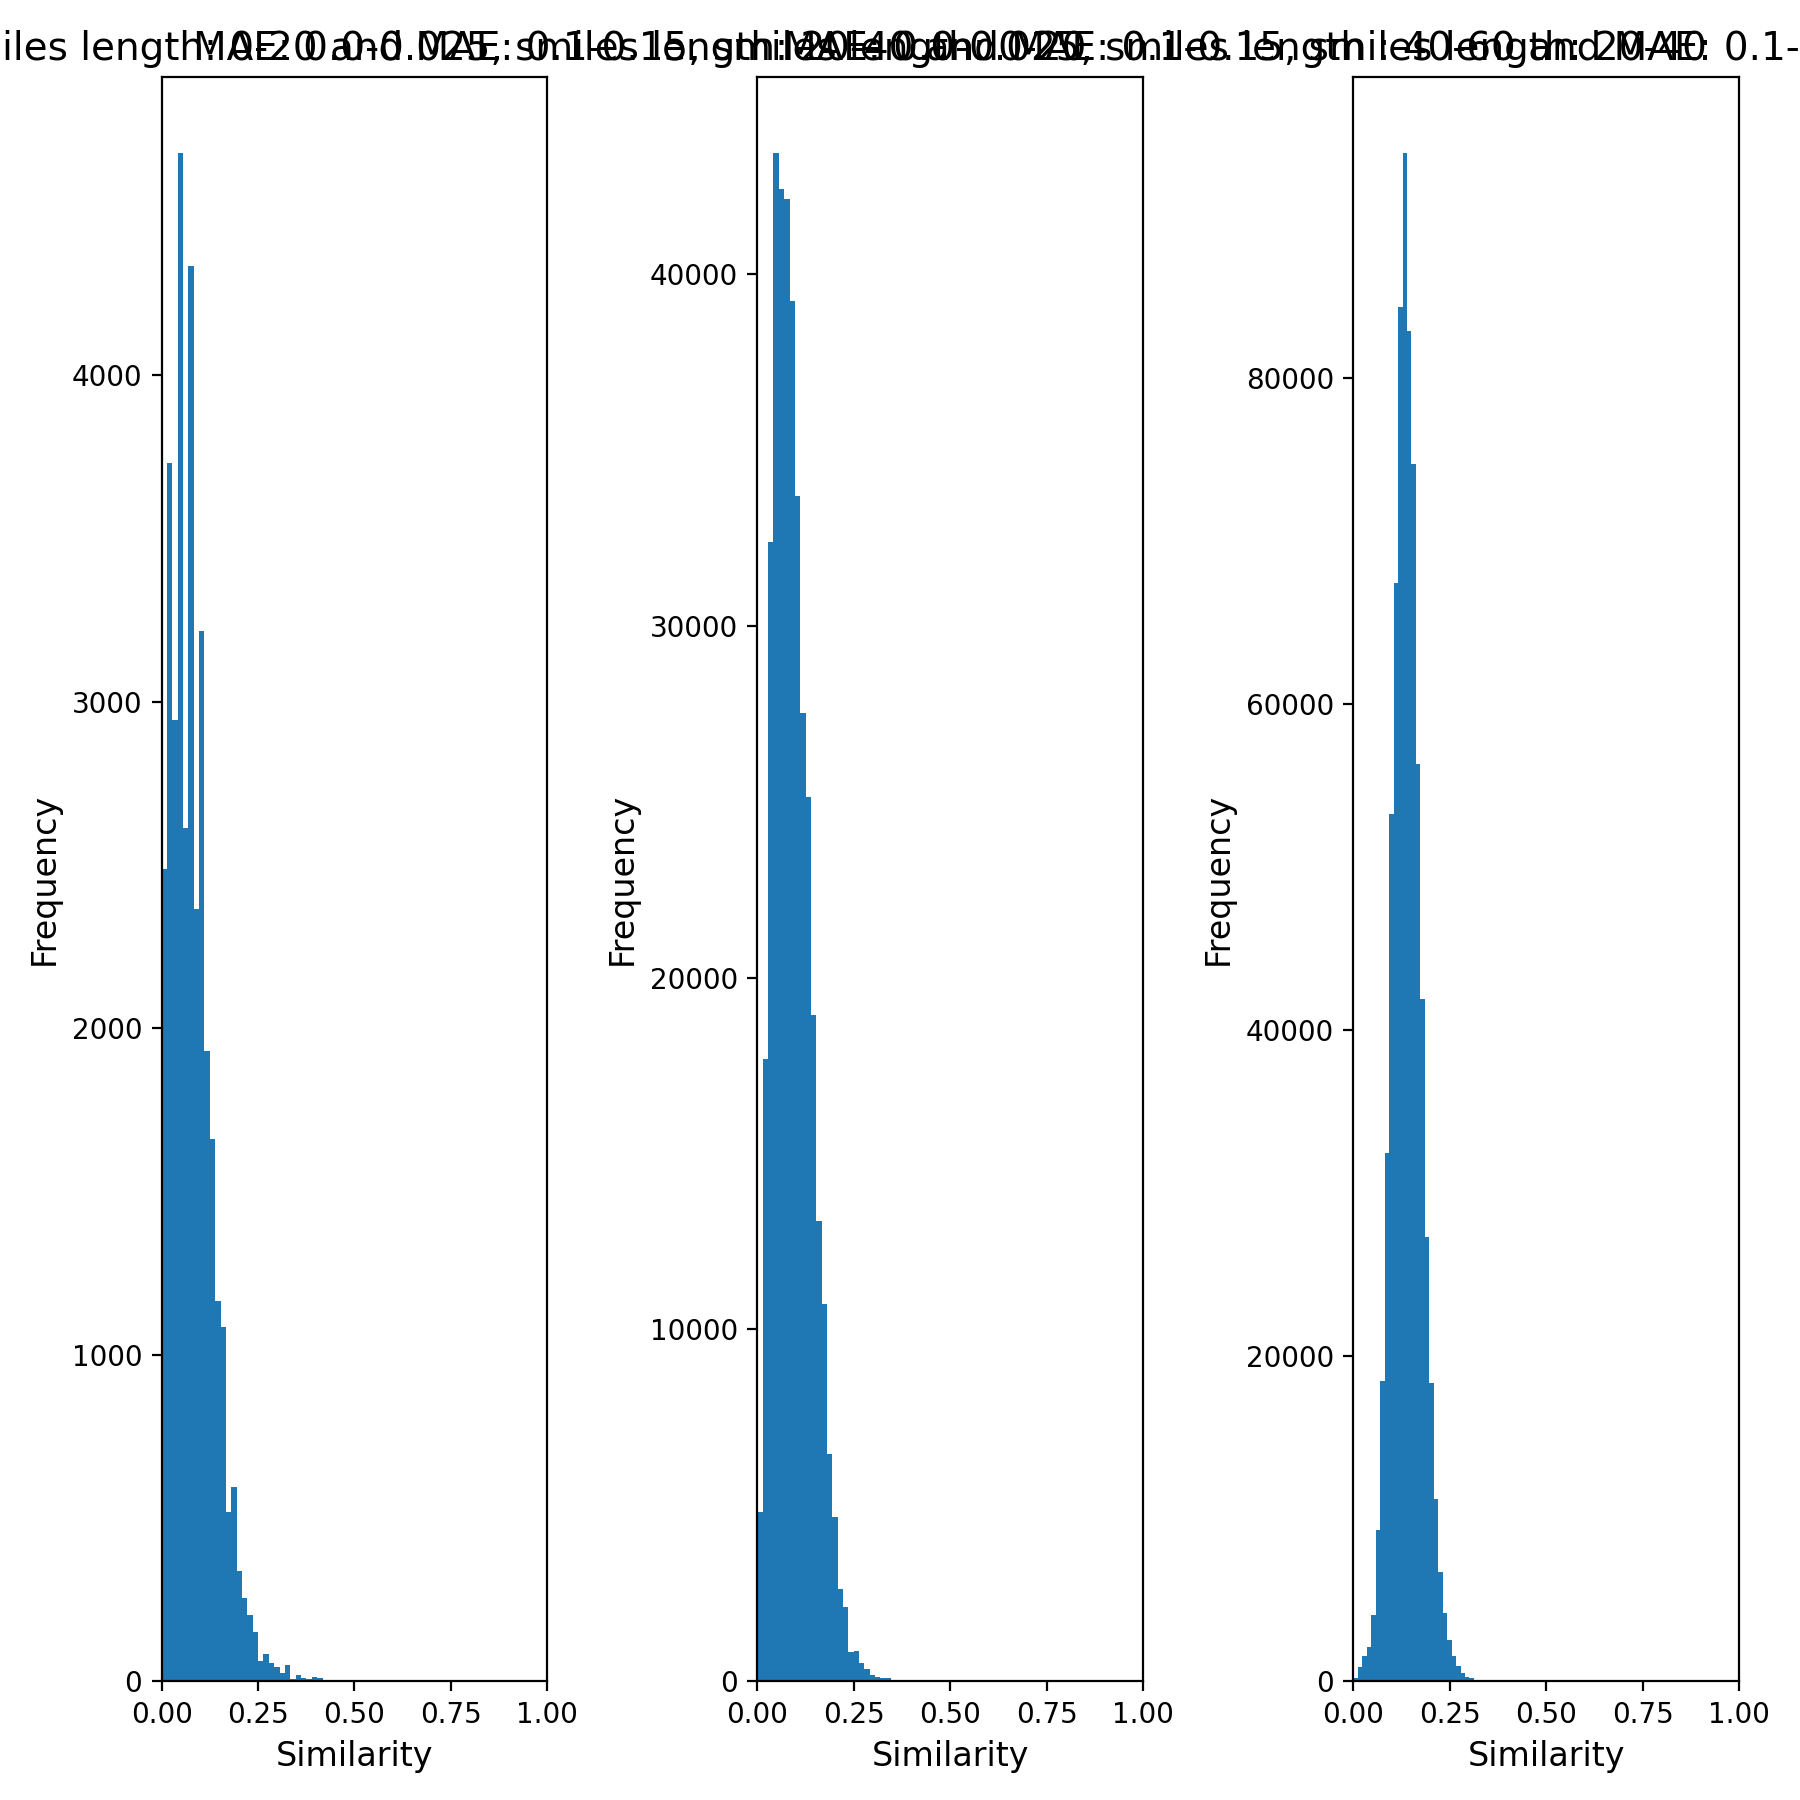

In [176]:

# Comapare the simularity between molecules in small 0 and small 4
df_subset_unions = []
settings = []
df_subset_union = df_main.query("((MAE > 0.0 and MAE < 0.025) and (smiles_len > 0 and smiles_len < 20)) or ((MAE > 0.1 and MAE < 0.15) and (smiles_len > 0 and smiles_len < 20))")
settings.append('MAE: 0.0-0.025, smiles length: 0-20 and MAE: 0.1-0.15, smiles length: 0-20')
df_subset_unions.append(df_subset_union)
df_subset_union = df_main.query('MAE > 0.0 and MAE < 0.025 and smiles_len > 20 and smiles_len < 40 or MAE > 0.1 and MAE < 0.15 and smiles_len > 20 and smiles_len < 40')
settings.append('MAE: 0.0-0.025, smiles length: 20-40 and MAE: 0.1-0.15, smiles length: 20-40')
df_subset_unions.append(df_subset_union)
df_subset_union = df_main.query('MAE > 0.0 and MAE < 0.025 and smiles_len > 40 and smiles_len < 60 or MAE > 0.1 and MAE < 0.15 and smiles_len > 40 and smiles_len < 60')
df_subset_unions.append(df_subset_union)
settings.append('MAE: 0.0-0.025, smiles length : 40-60 and MAE: 0.1-0.15, smiles length: 40-60')




fig, axs = plt.subplots(3, 1, figsize=(9, 9))
for i, df_subset_union in enumerate(df_subset_unions):
    # Remove dataset train
    df_subset_union = df_subset_union.drop(df_subset_union[df_subset_union['dataset'] == 'train'].index)
    # Remove model 3DMolMS_CS
    df_subset_union = df_subset_union.drop(df_subset_union[df_subset_union['model'] == '3DMolMS_CS'].index)
    # Put unique group_id in a list
    a_smiles_vec = df_subset_union['smiles'].unique()
    # Sort smiles_vec based on the length of the smiles
    a_smiles_vec = sorted(a_smiles_vec, key=len)
    df_sim = get_mol_sim(a_smiles_vec)

    # Plot the distribution of the similarities using matplotlib
    ax = axs[i]
    ax.hist(df_sim['Similarity'], bins=50)
    ax.set_title(settings[i], size = 14)
    ax.set_xlabel('Similarity', size=12)
    ax.set_ylabel('Frequency', size = 12)
    # Set axis limits
    ax.set_xlim(0, 1)
    #ax.set_ylim(0, )
    
plt.tight_layout()
plt.show()